# Project: Investigate a Dataset - [Database_soccer]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> In this project, I willl be analysing ultimate soccer dataset, which is an open-source dataset in kaggle. The dataset is a one .sql file comprising seven tables, each with different(unique) but interrelated features. First, Country table has 11 European countries. Second, league table has 11 lead championship names. The country and league tables are related by their ID. Third, match table has over 25, 000 matches for different seasons as well as betting odds from upto 10 providers. The match table is also related to the previous tables by country_id.


### Question(s) for Analysis
1. What is the league table for the 4 major leagues in europe during 2015/2016 season?
2. Which are the top 3 teams for each league in 2015/2016 season? 
3. What teams improved the most over the time period?

In [61]:
# import statements for all of the packages to be used.

import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

I want to create a function that would read csv and load for very dataset to a name variable

In [62]:
# creating function to load data
path='C:/Users/Davie/Desktop/Data/'
def load_data(name, table_name):
    name=pd.read_csv(path + 'Database_Soccer/'+ table_name) # reads the csv file and stores in the dataframe name
    return name

displaying few lines of each dataset from the soccer database

In [63]:
country=load_data('country', 'Country.csv')# country data table
country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [64]:
league=load_data('league', 'League.csv')# league data table
league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


From the league name above, the league name for Germany is confusing. Germany 1. could mean there are a number of German countries, so it should be change to Germany Bundesliga 1

In [65]:
match=load_data('match', 'Match.csv')# match data table
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


missing data in match table

In [66]:
player=load_data('player', 'Player.csv')# player data table
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


The birthday contains time at 00:00:00, which could be removed to contain only year, month and date

In [67]:
player_attr=load_data('player_attr', 'Player_Attributes.csv') # player attributes data table
player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


The time 00:00:00 can be removed

In [68]:
team=load_data('team', 'Team.csv')# team data table
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


The column team_fifa_api_id could insignificant because there is already team_api_id

In [69]:
team_attr=load_data('team_attr', 'Team_Attributes.csv')# team attributes data table
team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


I want again to develop a function that I will be using in inspecting the datasets for missing data, getting descriptive statistics, dimensions, and features' data types

In [70]:
# creating function for inspecting the datasets
def wrangles (tbl_name):
    
    inf=tbl_name.info(); # inspecting data types and instances with missing data 
    dim=tbl_name.shape; # inspecting dimensions of the dataset
    desc=tbl_name.describe(); # getting descriptive statistics
        
    return inf, dim, desc

In [71]:
# country dataset
wrangles(country)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


(None,
 (11, 2),
                  id
 count     11.000000
 mean   12452.090909
 std     8215.308472
 min        1.000000
 25%     6289.000000
 50%    13274.000000
 75%    18668.000000
 max    24558.000000)

There is no need of getting the mean for ids, since the names are string we can just unique values and counts 

In [72]:
country.name.describe()

count          11
unique         11
top       Belgium
freq            1
Name: name, dtype: object

In [73]:
# league data
wrangles(league)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


(None,
 (11, 3),
                  id    country_id
 count     11.000000     11.000000
 mean   12452.090909  12452.090909
 std     8215.308472   8215.308472
 min        1.000000      1.000000
 25%     6289.000000   6289.000000
 50%    13274.000000  13274.000000
 75%    18668.000000  18668.000000
 max    24558.000000  24558.000000)

There is no need of getting the mean for ids, since the names are string we can just unique values and counts

In [74]:
league.name.describe()

count                         11
unique                        11
top       Belgium Jupiler League
freq                           1
Name: name, dtype: object

In [75]:
# match data
wrangles(match)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


(None,
 (25979, 115),
                  id    country_id     league_id         stage  match_api_id  \
 count  25979.000000  25979.000000  25979.000000  25979.000000  2.597900e+04   
 mean   12990.000000  11738.630317  11738.630317     18.242773  1.195429e+06   
 std     7499.635658   7553.936759   7553.936759     10.407354  4.946279e+05   
 min        1.000000      1.000000      1.000000      1.000000  4.831290e+05   
 25%     6495.500000   4769.000000   4769.000000      9.000000  7.684365e+05   
 50%    12990.000000  10257.000000  10257.000000     18.000000  1.147511e+06   
 75%    19484.500000  17642.000000  17642.000000     27.000000  1.709852e+06   
 max    25979.000000  24558.000000  24558.000000     38.000000  2.216672e+06   
 
        home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
 count      25979.000000      25979.000000    25979.000000    25979.000000   
 mean        9984.371993       9984.475115        1.544594        1.160938   
 std        14087.4537

missing data for column home_player_x1

In [76]:
match.dtypes

id              int64
country_id      int64
league_id       int64
season         object
stage           int64
               ...   
GBD           float64
GBA           float64
BSH           float64
BSD           float64
BSA           float64
Length: 115, dtype: object

the date has been stored as a string

In [77]:
# player data
wrangles(player)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


(None,
 (11060, 7),
                  id  player_api_id  player_fifa_api_id        height  \
 count  11060.000000   11060.000000        11060.000000  11060.000000   
 mean    5537.511392  156582.427215       165664.910488    181.867445   
 std     3197.692647  160713.700624        58649.928360      6.369201   
 min        1.000000    2625.000000            2.000000    157.480000   
 25%     2767.750000   35555.500000       151889.500000    177.800000   
 50%     5536.500000   96619.500000       184671.000000    182.880000   
 75%     8306.250000  212470.500000       203883.250000    185.420000   
 max    11075.000000  750584.000000       234141.000000    208.280000   
 
              weight  
 count  11060.000000  
 mean     168.380289  
 std       14.990217  
 min      117.000000  
 25%      159.000000  
 50%      168.000000  
 75%      179.000000  
 max      243.000000  )

birthday column stored as string

In [78]:
# player attributes data
wrangles(player_attr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

(None,
 (183978, 42),
                  id  player_fifa_api_id  player_api_id  overall_rating  \
 count  183978.00000       183978.000000  183978.000000   183142.000000   
 mean    91989.50000       165671.524291  135900.617324       68.600015   
 std     53110.01825        53851.094769  136927.840510        7.041139   
 min         1.00000            2.000000    2625.000000       33.000000   
 25%     45995.25000       155798.000000   34763.000000       64.000000   
 50%     91989.50000       183488.000000   77741.000000       69.000000   
 75%    137983.75000       199848.000000  191080.000000       73.000000   
 max    183978.00000       234141.000000  750584.000000       94.000000   
 
            potential       crossing      finishing  heading_accuracy  \
 count  183142.000000  183142.000000  183142.000000     183142.000000   
 mean       73.460353      55.086883      49.921078         57.266023   
 std         6.592271      17.242135      19.038705         16.488905   
 min     

dates stored as string

In [79]:
# team data
wrangles(team)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


(None,
 (299, 5),
                  id    team_api_id  team_fifa_api_id
 count    299.000000     299.000000        288.000000
 mean   23735.301003   12340.521739      21534.305556
 std    15167.914719   25940.411135      42456.439408
 min        1.000000    1601.000000          1.000000
 25%     9552.500000    8349.000000        178.750000
 50%    22805.000000    8655.000000        673.500000
 75%    36250.500000    9886.500000       1910.750000
 max    51606.000000  274581.000000     112513.000000)

Missing data for team_fifa_api_id, though this might be insignificant since there is already team_api_id

In [80]:
# team attributes data
wrangles(team_attr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

(None,
 (1458, 25),
                 id  team_fifa_api_id    team_api_id  buildUpPlaySpeed  \
 count  1458.000000       1458.000000    1458.000000       1458.000000   
 mean    729.500000      17706.982167    9995.727023         52.462277   
 std     421.032659      39179.857739   13264.869900         11.545869   
 min       1.000000          1.000000    1601.000000         20.000000   
 25%     365.250000        110.000000    8457.750000         45.000000   
 50%     729.500000        485.000000    8674.000000         52.000000   
 75%    1093.750000       1900.000000    9904.000000         62.000000   
 max    1458.000000     112513.000000  274581.000000         80.000000   
 
        buildUpPlayDribbling  buildUpPlayPassing  chanceCreationPassing  \
 count            489.000000         1458.000000            1458.000000   
 mean              48.607362           48.490398              52.165295   
 std                9.678290           10.896101              10.360793   
 min        

Missing data for buildUpPlayDribbling


### Data Cleaning

First, I want to create functions that will help me drop duplicates, merge two datasets, change data type, remove missing rows, drop unnecessary columns, then proceed to to merge the country data to that for league. 
I will correct the league name for Germany 1. Bundesliga to Germany Bundesliga 1.
I will also change the name column for both the country data and league data, and also make the datafrmaes have the same dimensions and finally merge the two dataframes into country_league data using the country id as the key

In [81]:
# creating function to rename columns in a data frame
def col_rename(col_renamed_data, col_old, col_new):
    if len(col_old)==2: # checks if there are two columns to be renamed
        col_renamed_data.rename(columns={col_old[0]:col_new[0], col_old[1]:col_new[1]}, inplace=True) # renames the two columns in the dataset
    else:
        col_renamed_data.rename(columns={col_old:col_new}, inplace=True) # renames if there is only one column to be renamed
        
    return col_renamed_data

In [82]:
# creating a function drop columns
def drop_cols(drop_col_data, col_name):
    drop_col_data.drop(col_name, axis=1, inplace=True) # removing columns
        
    return drop_col_data

In [83]:
# creating a function to remove row missing values
def remove_row_missing_values(na_data):
    na_data.dropna(axis=0, how='any', inplace=True) # removing all rows with missing values
        
    return na_data

In [84]:
# creating a function to remove duplicate rows
def remove_duplicates(dup_data, col):
    if col=='':
        dup_data.drop_duplicates(inplace=True) # remove all duplicate rows
        
    else:
        dup_data.dropna(subset=[col], inplace=True) # removing rows based on column duplicate values
        
    return dup_data

In [85]:
# creating a function to change date column from string to datetime
def changed_type(changed_type_data, col_type):
    changed_type_data[col_type]=changed_type_data[col_type].astype('str')  # converting to string
    changed_type_data[col_type]=changed_type_data[col_type].str.extract(r'(\d{4}-\d{2}-\d{2})') # extracting the date
    changed_type_data[col_type] = pd.to_datetime(changed_type_data[col_type], format='%Y-%m-%d') # converting to datetime

    return changed_type_data

In [86]:
# creating a function to filter some columns
def filter_col(f_data, col):
    df=f_data.filter(col) # filters the columns
        
    return df

In [87]:
# creating a function to to merge two data frames using inner because i dont want do keep duplicates
def merging_data(data1, data2, on_col):
    df=data1.merge(data2, on =on_col, how='inner')
        
    return df

In [88]:
# correcting the league name for Germany 1. Bundesliga
league.replace(to_replace='Germany 1. Bundesliga', value='Germany Bundesliga 1', inplace=True)

In [89]:
# changing both id and name columns for the country data
country=col_rename(country, col_old=['name', 'id'], col_new=['country_name', 'country_id']) 
country 

,country_id,country_name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [90]:
# changing the name column and id column  for the league data
league=col_rename(league, col_old=['name', 'id'], col_new=['league_name', 'league_id']) 
league

,league_id,country_id,league_name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany Bundesliga 1
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [91]:
# merging the two dataframes country and league
country_league_info=merging_data(country, league, on_col ='country_id')
country_league_info

,country_id,country_name,league_id,league_name
0,1,Belgium,1,Belgium Jupiler League
1,1729,England,1729,England Premier League
2,4769,France,4769,France Ligue 1
3,7809,Germany,7809,Germany Bundesliga 1
4,10257,Italy,10257,Italy Serie A
5,13274,Netherlands,13274,Netherlands Eredivisie
6,15722,Poland,15722,Poland Ekstraklasa
7,17642,Portugal,17642,Portugal Liga ZON Sagres
8,19694,Scotland,19694,Scotland Premier League
9,21518,Spain,21518,Spain LIGA BBVA


Second, I want to merge the player data to player attributes data into player_info dataframe.
I will use either the player_api_id or player_fifa_api_id as the keys and drop the id columns in both datasets


In [92]:
# checking the number of unique values of player_api_id on payer and player attribute data
player.player_api_id.nunique()==player_attr.player_api_id.nunique()

True

In [93]:
# checking the number of unique values of  player_fifa_api_id on player and player attribute data
player.player_fifa_api_id.nunique()==player_attr.player_fifa_api_id.nunique()

False

Since the number of unique values of the player_fifa_api_id are not the same in both dataframes, I will just use both of them as the key because both the ids might be important in merging this data with another one

In [94]:
# dropping id column from player dataframe
drop_cols(player, col_name='id')
player.head(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [95]:
# dropping id column from player_attr dataframe
drop_cols(player_attr, col_name='id')
player_attr.head(5)

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [96]:
# removing duplicates for player attribute data
remove_duplicates(player_attr, col='').head(5)

,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [97]:
# joining the two dataframes on player_api_id and player_fifa_api_id using inner join because i dont want the unmatched rows
player_info=merging_data(player, player_attr, on_col =['player_api_id', 'player_fifa_api_id'])
player_info.head(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


I now want to examine the player_info dataframe, check for missing values, dimensions of each column, data types of each column as well as duplcate values

In [98]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183766 entries, 0 to 183765
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        183766 non-null  int64  
 1   player_name          183766 non-null  object 
 2   player_fifa_api_id   183766 non-null  int64  
 3   birthday             183766 non-null  object 
 4   height               183766 non-null  float64
 5   weight               183766 non-null  int64  
 6   date                 183766 non-null  object 
 7   overall_rating       183016 non-null  float64
 8   potential            183016 non-null  float64
 9   preferred_foot       183016 non-null  object 
 10  attacking_work_rate  180622 non-null  object 
 11  defensive_work_rate  183016 non-null  object 
 12  crossing             183016 non-null  float64
 13  finishing            183016 non-null  float64
 14  heading_accuracy     183016 non-null  float64
 15  short_passing    

From the above uotput, there are several missing values, the data type for birthday and date are all strings. I have also noted that attacking_work_rate has the least number of rows hence maximum number of missing values

In [99]:
# getting the uniques for the coulmn attacking_work_rate
player_info.attacking_work_rate.unique()

array(['medium', 'high', nan, 'low', 'None', 'le', 'norm', 'stoc', 'y'],
      dtype=object)

In [100]:
# getting the uniques for the coulmn attacking_work_rate
player_info.defensive_work_rate.unique()

array(['medium', 'high', 'low', '_0', nan, '5', 'ean', 'o', '1', 'ormal',
       '7', '2', '8', '4', 'tocky', '0', '3', '6', '9', 'es'],
      dtype=object)

From the output in above two cells, no information has been provided from the data description about the meaning of None, norm, y, stoc, le, ornal, es, tocky, ean o, and the numbers 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9 . Howerver, from inspection, I realize that there is some association in that all the numbers 0-9 and o on the defensive_work_rate relates to None  on the attacking_work_rate. Also, the following  pairs also relate: norm-ornal, y-es, stoc-tocky, le-ean. These could be change or transformed if additional information is provided or simply be dropped from the analysis

In [101]:
attacking_none=player_info.query('attacking_work_rate=="None"')
attacking_none.head(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
675,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-03-24 00:00:00,73.0,75.0,right,...,71.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
676,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-02-25 00:00:00,72.0,74.0,right,...,71.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
677,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2016-01-07 00:00:00,72.0,74.0,right,...,74.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
678,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2015-09-21 00:00:00,72.0,74.0,right,...,74.0,68.0,44.0,36.0,24.0,8.0,14.0,14.0,8.0,13.0
679,194479,"Abdoulaye Diallo Sadio,22",204171,1990-12-28 00:00:00,182.88,168,2015-07-03 00:00:00,71.0,73.0,right,...,73.0,67.0,43.0,35.0,23.0,7.0,13.0,13.0,7.0,12.0


In [102]:
# comparing length of numbers 0-9 and o in the defensive_work_rate relates to None in the attacking_work_rate
attacking_none.attacking_work_rate.value_counts()==attacking_none.defensive_work_rate.value_counts().sum()

None    True
Name: attacking_work_rate, dtype: bool

- None: This likely means no specific attacking work rate is assigned. Treat it as a default or neutral value - null/medium.
- le: This could be an abbreviation for "less effort" or something similar. map it to a "Low" attacking work rate.
- norm: This probably stands for "normal.map it to a "Medium" attacking work rate.
- stoc: This might be short for "stock" or default settings. map it to "Medium."
- y: This is unclear, but it might be a placeholder or a specific setting in a custom game mode. Remove
- I want to drop all rows with nan and duplicate rows

In [103]:
attacking_work_rate_mapping={
    'None': np.NAN,
    'le': 'low',
    'norm': 'medium',
    'stoc': 'medium',
    'y': np.NAN
}
player_info['attacking_work_rate']=player_info['attacking_work_rate'].replace(attacking_work_rate_mapping)

In [104]:
player_info['attacking_work_rate'].unique()

array(['medium', 'high', nan, 'low'], dtype=object)

- 5, 1, 7, 2, 8, 4, 0, 3, 6, 9: mapping based on the context or frequency of these values.
- ean: Possibly a typo for "mean" or "lean." map it to "Medium" or "Low."
- o: Could be a typo or placeholder. Remove
- ormal: Likely a typo for "normal," which you can map to "Medium."
- tocky: Possibly a typo for "stocky," which might imply a strong defensive presence. map it to "High."
- es: Could be a typo for "yes" or another term. Remove

In [105]:
defensive_work_rate_mapping = {
    '0': 'low',
    '1': 'low',
    '2': 'low',
    '3': 'low',
    '4': 'medium',
    '5': 'medium',
    '6': 'medium',
    '7': 'high',
    '8': 'high',
    '9': 'high',
    'ean':'low',
    'ormal': 'medium',
    'tocky': 'high',
    'o':np.nan,
    'es':np.nan
}
player_info['defensive_work_rate']=player_info['defensive_work_rate'].replace(defensive_work_rate_mapping)

In [106]:
player_info['defensive_work_rate'].unique()

array(['medium', 'high', 'low', '_0', nan], dtype=object)

In [107]:
# dropping all rows with missing data
remove_row_missing_values(player_info).head(5) 

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [108]:
# dropping duplicate rows
remove_duplicates(player_info, col='').head(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [109]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176847 entries, 0 to 183765
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        176847 non-null  int64  
 1   player_name          176847 non-null  object 
 2   player_fifa_api_id   176847 non-null  int64  
 3   birthday             176847 non-null  object 
 4   height               176847 non-null  float64
 5   weight               176847 non-null  int64  
 6   date                 176847 non-null  object 
 7   overall_rating       176847 non-null  float64
 8   potential            176847 non-null  float64
 9   preferred_foot       176847 non-null  object 
 10  attacking_work_rate  176847 non-null  object 
 11  defensive_work_rate  176847 non-null  object 
 12  crossing             176847 non-null  float64
 13  finishing            176847 non-null  float64
 14  heading_accuracy     176847 non-null  float64
 15  short_passing    

In [110]:
player_info.attacking_work_rate.value_counts()

medium    125425
high       42775
low         8647
Name: attacking_work_rate, dtype: int64

In [111]:
player_info.defensive_work_rate.value_counts()

medium    131109
high       27094
low        18644
Name: defensive_work_rate, dtype: int64

I want to change the data types for birthday and date from string to datetime

In [112]:
# converting birthday column into datetime
changed_type(player_info, col_type='birthday').head(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2016-02-18 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-11-19 00:00:00,67.0,71.0,right,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-09-21 00:00:00,62.0,66.0,right,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2015-03-20 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,218353,1992-02-29,182.88,187,2007-02-22 00:00:00,61.0,65.0,right,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [113]:
# converting date column into datetime
changed_type(player_info, col_type='date').tail(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
183761,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,2009-08-30,83.0,85.0,right,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183762,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,2009-02-22,78.0,80.0,right,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183763,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,2008-08-30,77.0,80.0,right,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183764,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,2007-08-30,78.0,81.0,right,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0
183765,39902,Zvjezdan Misimovic,102359,1982-06-05,180.34,176,2007-02-22,80.0,81.0,right,...,88.0,53.0,38.0,32.0,30.0,9.0,9.0,78.0,7.0,15.0


In [114]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176847 entries, 0 to 183765
Data columns (total 45 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_api_id        176847 non-null  int64         
 1   player_name          176847 non-null  object        
 2   player_fifa_api_id   176847 non-null  int64         
 3   birthday             176847 non-null  datetime64[ns]
 4   height               176847 non-null  float64       
 5   weight               176847 non-null  int64         
 6   date                 176847 non-null  datetime64[ns]
 7   overall_rating       176847 non-null  float64       
 8   potential            176847 non-null  float64       
 9   preferred_foot       176847 non-null  object        
 10  attacking_work_rate  176847 non-null  object        
 11  defensive_work_rate  176847 non-null  object        
 12  crossing             176847 non-null  float64       
 13  finishing     

In [115]:
player_info.sample(5)

,player_api_id,player_name,player_fifa_api_id,birthday,height,weight,date,overall_rating,potential,preferred_foot,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
111057,362113,Marco Benassi,211354,1994-05-05,182.88,176,2013-09-20,68.0,80.0,right,...,64.0,36.0,41.0,63.0,55.0,11.0,7.0,5.0,12.0,14.0
40920,39222,Davide Biondini,162174,1983-01-24,180.34,170,2009-02-22,74.0,80.0,right,...,77.0,70.0,62.0,78.0,77.0,9.0,21.0,76.0,21.0,21.0
164070,39455,Sokratis Papastathopoulos,172879,1988-06-09,185.42,187,2013-03-08,78.0,81.0,right,...,39.0,64.0,80.0,82.0,77.0,6.0,8.0,5.0,12.0,5.0
27975,38373,Cheik Tiote,170783,1986-06-21,180.34,190,2013-03-08,80.0,83.0,right,...,72.0,51.0,81.0,83.0,79.0,5.0,5.0,11.0,8.0,8.0
13261,30886,Andrey Voronin,114123,1979-07-21,175.26,179,2007-02-22,76.0,85.0,left,...,73.0,75.0,33.0,42.0,20.0,14.0,13.0,56.0,10.0,13.0


Third, I want merge team data to team attributes data into into team info dataframe, check data types, missing values

In [116]:
# checking the number of unique values of team_api_id in team and team attribute data
team.team_api_id.nunique()==team_attr.team_api_id.nunique()

False

In [117]:
# checking the number of unique values of team_fifa_api_id in team and team attribute data
team.team_fifa_api_id.nunique()==team_attr.team_fifa_api_id.nunique()

True

From these outputs, it is clear that neither the team_api_id nor the team_fifa_api_id matches in the two datasets. I will therefore merge them on both the team_api_id and team_fifa_api_id as the keys

In [118]:
team.head(5)

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [119]:
# dropping the id for team dataframe
drop_cols(team, col_name='id').drop_duplicates(subset='team_api_id')

,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,9987,673.0,KRC Genk,GEN
1,9993,675.0,Beerschot AC,BAC
2,10000,15005.0,SV Zulte-Waregem,ZUL
3,9994,2007.0,Sporting Lokeren,LOK
4,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...
294,10190,898.0,FC St. Gallen,GAL
295,10191,1715.0,FC Thun,THU
296,9777,324.0,Servette FC,SER
297,7730,1862.0,FC Lausanne-Sports,LAU


In [120]:
x = []

for i in team.team_long_name.unique():
    i = str(i).strip()
    # Match strings
    if re.search(r'[^a-zA-Z\s]', i):
        x.append(i)

print(f"Result: {x}")

Result: ['SV Zulte-Waregem', 'Standard de Liège', 'Sint-Truidense VV', 'Oud-Heverlee Leuven', 'Waasland-Beveren', 'Paris Saint-Germain', 'AS Nancy-Lorraine', 'FC Sochaux-Montbéliard', 'Grenoble Foot 38', 'AS Saint-Étienne', 'Montpellier Hérault SC', "US Boulogne Cote D'Opale", 'AC Arles-Avignon', 'Stade Brestois 29', 'Évian Thonon Gaillard FC', 'Bayer 04 Leverkusen', 'FC Schalke 04', 'Hannover 96', '1. FC Köln', 'TSG 1899 Hoffenheim', 'Borussia Mönchengladbach', '1. FC Nürnberg', '1. FSV Mainz 05', '1. FC Kaiserslautern', 'FC St. Pauli', 'Fortuna Düsseldorf', 'SpVgg Greuther Fürth', 'SC Paderborn 07', 'FC Ingolstadt 04', 'SV Darmstadt 98', 'N.E.C.', 'VVV-Venlo', 'Wisła Kraków', 'Ruch Chorzów', 'P. Warszawa', 'Śląsk Wrocław', 'Lechia Gdańsk', 'Widzew Łódź', 'Odra Wodzisław', 'Lech Poznań', 'GKS Bełchatów', 'Jagiellonia Białystok', 'Zagłębie Lubin', 'Podbeskidzie Bielsko-Biała', 'Pogoń Szczecin', 'Górnik Łęczna', 'Termalica Bruk-Bet Nieciecza', 'Vitória Guimarães', 'Vitória Setúbal', 'FC

I want to correct the following team names: '1. FC Köln', '1. FC Nürnberg', '1. FSV Mainz 05','1. FC Kaiserslautern' and some other names

In [121]:
# correcting some team names
team.team_long_name.replace(to_replace=['1. FC Köln', '1. FC Nürnberg', '1. FSV Mainz 05','1. FC Kaiserslautern'], 
                            value=['FC Köln', 'FC Nürnberg', 'FSV Mainz 05','FC Kaiserslautern'], inplace=True)

In [122]:
name_dict={
    'FC Köln': 'FC Cologne',
    'FC Nürnberg': 'FC Nuremberg',
    'Wisła Kraków': 'Wisla Krakow',
    'Ruch Chorzów': 'Ruch Chorzow',
    'Śląsk Wrocław': 'Slask Wroclaw',
    'Lechia Gdańsk': 'Lechia Gdansk',
    'Widzew Łódź': 'Widzew Lodz',
    'Odra Wodzisław': 'Odra Wodzislaw',
    'Lech Poznań': 'Lech Poznan',
    'GKS Bełchatów': 'GKS Belchatow',
    'Jagiellonia Białystok': 'Jagiellonia Bialystok',
    'Zagłębie Lubin': 'Zaglebie Lubin',
    'Pogoń Szczecin': 'Pogon Szczecin',
    'Górnik Łęczna': 'Gornik Leczna',
    'Vitória Guimarães': 'Vitoria Guimaraes',
    'Vitória Setúbal': 'Vitoria Setubal',
    'CS Marítimo': 'CS Maritimo',
    'União de Leiria, SAD': 'Uniao de Leiria',
    'RC Deportivo de La Coruña': 'Deportivo La Coruna',
    'Real Sporting de Gijón': 'Sporting Gijon',
    'Real Betis Balompié': 'Real Betis',
    'UD Almería': 'UD Almeria',
    'Atlético Madrid': 'Atletico Madrid',
    'Málaga CF': 'Malaga CF',
    'Hércules Club de Fútbol': 'Hercules CF',
    'Córdoba CF': 'Cordoba CF',
    'Grasshopper Club Zürich': 'Grasshopper Club Zurich',
    'Neuchâtel Xamax': 'Neuchatel Xamax',
    'FC Zürich': 'FC Zurich',
    "US Boulogne Cote D'Opale": "US Boulogne Côte d'Opale",
    "SpVgg Greuther Fürth": "SpVgg Greuther Fürth", 
    "N.E.C.": "N.E.C. Nijmegen",
    "P. Warszawa": "Polonia Warszawa",
    "SC Olhanense": "SC Olhanense",
    "Partick Thistle F.C.": "Partick Thistle FC",
    "FC Lausanne-Sports": "FC Lausanne-Sport"
}

In [123]:
team.team_long_name.replace(to_replace=name_dict, inplace=True)

In [124]:
team_attr.dropna(how='any').drop_duplicates(subset='team_api_id').head(5)

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
7,8,77,8485,2014-09-19 00:00:00,58,Balanced,64.0,Normal,62,Mixed,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
13,14,614,8576,2014-09-19 00:00:00,59,Balanced,57.0,Normal,52,Mixed,...,52,Normal,Organised,38,Medium,47,Press,53,Normal,Cover
19,20,47,8564,2014-09-19 00:00:00,48,Balanced,70.0,Lots,52,Mixed,...,75,Lots,Organised,58,Medium,57,Press,49,Normal,Cover
25,26,1901,10215,2014-09-19 00:00:00,52,Balanced,53.0,Normal,44,Mixed,...,60,Normal,Organised,39,Medium,38,Press,61,Normal,Cover


In [125]:
# dropping the id for team attributes data
drop_cols(team_attr, col_name='id').head(5)

,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [126]:
# merging team to the team attribute
team_info=team.merge(team_attr, on =['team_api_id', 'team_fifa_api_id'], how='inner') #
team_info['team_fifa_api_id']=team_info['team_fifa_api_id'].astype(int)
team_info.head(5)

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673,KRC Genk,GEN,2010-02-22 00:00:00,45,Balanced,NaN,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673,KRC Genk,GEN,2011-02-22 00:00:00,66,Balanced,NaN,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673,KRC Genk,GEN,2012-02-22 00:00:00,53,Balanced,NaN,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673,KRC Genk,GEN,2013-09-20 00:00:00,58,Balanced,NaN,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673,KRC Genk,GEN,2014-09-19 00:00:00,58,Balanced,52.0,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover


I will populate the NaN in the buildUpPlayDribbling column with the mean of the column. And finally drop duplcates in the final dataframe

In [127]:
# converting to datetime
changed_type(team_info, col_type='date').head(5)

,team_api_id,team_fifa_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9987,673,KRC Genk,GEN,2010-02-22,45,Balanced,NaN,Little,45,...,60,Normal,Organised,70,High,65,Press,70,Wide,Cover
1,9987,673,KRC Genk,GEN,2011-02-22,66,Balanced,NaN,Little,52,...,51,Normal,Organised,48,Medium,47,Press,54,Normal,Offside Trap
2,9987,673,KRC Genk,GEN,2012-02-22,53,Balanced,NaN,Little,55,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
3,9987,673,KRC Genk,GEN,2013-09-20,58,Balanced,NaN,Little,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
4,9987,673,KRC Genk,GEN,2014-09-19,58,Balanced,52.0,Normal,38,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover


In [128]:
# dropping the duplicate rows in the final team info merged data
team_info=team_info.copy()
drop_cols(team_info, col_name=['team_fifa_api_id',])
team_info.drop_duplicates(subset='team_api_id')
team_info.dropna(how='any', inplace=True)
#remove_duplicates(team_info, col='')
team_info.head(5)

,team_api_id,team_long_name,team_short_name,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
4,9987,KRC Genk,GEN,2014-09-19,58,Balanced,52.0,Normal,38,Mixed,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
5,9987,KRC Genk,GEN,2015-09-10,58,Balanced,52.0,Normal,38,Mixed,...,56,Normal,Organised,36,Medium,57,Press,70,Wide,Cover
14,10000,SV Zulte-Waregem,ZUL,2014-09-19,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
15,10000,SV Zulte-Waregem,ZUL,2015-09-10,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
20,9994,Sporting Lokeren,LOK,2014-09-19,62,Balanced,45.0,Normal,52,Mixed,...,62,Normal,Organised,45,Medium,52,Press,52,Normal,Cover


Finally, I to examine and merge match data, country_league, and team data to form march info dataframe. I will check for duplicates, missing values and correct data types

In [129]:
# checking the number of league_id unique values in the match and country_league_info dataframes
match.league_id.nunique()==country_league_info.league_id.nunique()

True

In [130]:
# checking the number of country_id unique values in the match and country_league_info dataframes
match.country_id.nunique()==country_league_info.country_id.nunique()

True

I will merge match and country_league_info dataframes on league_id and country_id, so that I retain all the info about ids. I want to drop all the columns containing odds

In [131]:
for i in match.columns:
    print(i)

id
country_id
league_id
season
stage
date
match_api_id
home_team_api_id
away_team_api_id
home_team_goal
away_team_goal
home_player_X1
home_player_X2
home_player_X3
home_player_X4
home_player_X5
home_player_X6
home_player_X7
home_player_X8
home_player_X9
home_player_X10
home_player_X11
away_player_X1
away_player_X2
away_player_X3
away_player_X4
away_player_X5
away_player_X6
away_player_X7
away_player_X8
away_player_X9
away_player_X10
away_player_X11
home_player_Y1
home_player_Y2
home_player_Y3
home_player_Y4
home_player_Y5
home_player_Y6
home_player_Y7
home_player_Y8
home_player_Y9
home_player_Y10
home_player_Y11
away_player_Y1
away_player_Y2
away_player_Y3
away_player_Y4
away_player_Y5
away_player_Y6
away_player_Y7
away_player_Y8
away_player_Y9
away_player_Y10
away_player_Y11
home_player_1
home_player_2
home_player_3
home_player_4
home_player_5
home_player_6
home_player_7
home_player_8
home_player_9
home_player_10
home_player_11
away_player_1
away_player_2
away_player_3
away_player_4
a

I want to remove all the columns with CAPITAL LETTERS, odds columns

In [132]:
# converting to datetime for the match data
changed_type(match, col_type='date').head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [133]:
# dropping the duplicate rows from match data
remove_duplicates(match, col='').head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [134]:
# dropping the columns containg odds and the match id
odd_cols = list(filter(lambda x: x.isupper(), match.columns))
drop_cols(match, col_name=odd_cols)
drop_cols(match, col_name='id')
match.head(5)

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
match.columns

Index(['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id',
       'home_team_api_id', 'away_team_api_id', 'home_team_goal',
       'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7',
       'away_player_X8', 'away_player_X9', 'away_player_X10',
       'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7',
       'home_player_Y8', 'home_player_Y9', 'home_player_Y10',
       'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3',
       'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'away_player_Y8', 'away_player

### checking the contents of some columns
```match.goal.value_counts() # goal```

From the above two cells, I realised that the coulmns goal, shoton, shotoff, foulcommit, card, cross, corner and possession contains information related to the web page but not realistic data.Checking through the nested infomation, I can't really make sense out of it since even the website link to the discription is not loading. Instead of deleting the columns with such issues, I will instead drop the columns containing unprocessed data

In [136]:
match.columns
match_info=filter_col(match, col=['country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal'])

match_info.head(5)

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3


In [137]:
match_info['results'] = np.where(
    match_info['home_team_goal'] == match_info['away_team_goal'], 'draw',
    np.where(
        match_info['home_team_goal'] > match_info['away_team_goal'], 'home win', 'away win'
    )
)

match_info.head(5)

,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,results
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,draw
1,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,draw
2,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,away win
3,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,home win
4,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,away win


In [138]:
# Merging the data
match_info=merging_data(country_league_info, match_info, on_col =['country_id', 'league_id'])
match_info.sample(5)

,country_id,country_name,league_id,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,results
2344,1729,England,1729,England Premier League,2009/2010,30,2010-03-13,659114,8658,8668,2,2,draw
24114,21518,Spain,21518,Spain LIGA BBVA,2014/2015,38,2015-05-23,1778411,9910,8558,3,2,home win
14376,13274,Netherlands,13274,Netherlands Eredivisie,2011/2012,28,2012-04-01,1028933,8464,8526,2,0,home win
22774,21518,Spain,21518,Spain LIGA BBVA,2011/2012,2,2011-08-28,1051621,8315,8370,1,1,draw
10269,10257,Italy,10257,Italy Serie A,2008/2009,10,2008-11-01,539648,8690,8636,2,3,away win


In [139]:
match_info=match_info.drop(columns=['country_id', 'league_id'])
match_info.sample(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,results
4397,England,England Premier League,2015/2016,1,2015-08-10,1987041,8659,8456,0,3,away win
5638,France,France Ligue 1,2010/2011,2,2010-08-14,829878,108893,8588,0,1,away win
17896,Portugal,Portugal Liga ZON Sagres,2009/2010,10,2009-11-08,686249,7841,9768,2,2,draw
6718,France,France Ligue 1,2013/2014,14,2013-11-22,1468289,8576,8592,1,3,away win
14888,Netherlands,Netherlands Eredivisie,2013/2014,18,2013-12-21,1473180,9791,8277,2,2,draw


In [140]:
# melt home and away teams id_vars are columns not melted
# creating columns not melted
unmelted_columns= [x for x in match_info.columns if x not in ['home_team_api_id', 'away_team_api_id']]

# melting home and away teams api ids
melted_match=match_info.melt(id_vars=unmelted_columns, var_name='Location', value_name='Team')
melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,Team
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home_team_api_id,9987
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home_team_api_id,10000
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home_team_api_id,9984
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home_team_api_id,9991
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home_team_api_id,7947


In [141]:
# cleaning up or changing the location values
melted_match['Location']=melted_match['Location'].replace({'home_team_api_id':'home', 'away_team_api_id':'away'})
melted_df=melted_match.copy()

### merging the team_info to the melted_match

In [142]:
exclude_columns = ['team_long_name', 'team_short_name', 'date']
team_info = team_info.drop(columns=exclude_columns).drop_duplicates(subset='team_api_id')

team_info.head(5)

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
4,9987,58,Balanced,52.0,Normal,38,Mixed,Organised,67,Risky,...,56,Normal,Organised,47,Medium,45,Press,55,Normal,Cover
14,10000,54,Balanced,42.0,Normal,51,Mixed,Organised,47,Normal,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
20,9994,62,Balanced,45.0,Normal,52,Mixed,Organised,42,Normal,...,62,Normal,Organised,45,Medium,52,Press,52,Normal,Cover
26,9984,53,Balanced,49.0,Normal,43,Mixed,Organised,52,Normal,...,42,Normal,Organised,59,Medium,47,Press,62,Normal,Cover
32,8635,52,Balanced,46.0,Normal,51,Mixed,Organised,60,Normal,...,47,Normal,Organised,60,Medium,50,Press,65,Normal,Cover


In [143]:
team_info.rename(columns={'team_api_id':'Team'}, inplace=True)
team_s=team_info.copy()

In [144]:

melted_match=pd.merge(melted_df, team_s, on ='Team', how='left')
#melted_match.drop_duplicates(subset='match_api_id' , inplace=True)
melted_match.head(5)


,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,56.0,Normal,Organised,47.0,Medium,45.0,Press,55.0,Normal,Cover
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,32.0,Little,Organised,44.0,Medium,58.0,Press,37.0,Normal,Cover
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,42.0,Normal,Organised,59.0,Medium,47.0,Press,62.0,Normal,Cover
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,34.0,Normal,Organised,55.0,Medium,59.0,Press,52.0,Normal,Cover
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# creating team dictionary with team api ids as the key and a longname as the value
team_dict=team.set_index('team_api_id')['team_long_name'].to_dict()
team_dict

{9987: 'KRC Genk',
 9993: 'Beerschot AC',
 10000: 'SV Zulte-Waregem',
 9994: 'Sporting Lokeren',
 9984: 'KSV Cercle Brugge',
 8635: 'RSC Anderlecht',
 9991: 'KAA Gent',
 9998: 'RAEC Mons',
 7947: 'FCV Dender EH',
 9985: 'Standard de Liège',
 8203: 'KV Mechelen',
 8342: 'Club Brugge KV',
 9999: 'KSV Roeselare',
 8571: 'KV Kortrijk',
 4049: 'Tubize',
 9996: 'Royal Excel Mouscron',
 10001: 'KVC Westerlo',
 9986: 'Sporting Charleroi',
 9997: 'Sint-Truidense VV',
 9989: 'Lierse SK',
 6351: 'KAS Eupen',
 1773: 'Oud-Heverlee Leuven',
 8475: 'Waasland-Beveren',
 8573: 'KV Oostende',
 274581: 'Royal Excel Mouscron',
 10260: 'Manchester United',
 10261: 'Newcastle United',
 9825: 'Arsenal',
 8659: 'West Bromwich Albion',
 8472: 'Sunderland',
 8650: 'Liverpool',
 8654: 'West Ham United',
 8528: 'Wigan Athletic',
 10252: 'Aston Villa',
 8456: 'Manchester City',
 8668: 'Everton',
 8655: 'Blackburn Rovers',
 8549: 'Middlesbrough',
 8586: 'Tottenham Hotspur',
 8559: 'Bolton Wanderers',
 10194: 'Stoke

In [146]:
# cleaning up team i.e. using team dictionary to replace team api ids
melted_match['Team']=melted_match['Team'].map(team_dict)
melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,56.0,Normal,Organised,47.0,Medium,45.0,Press,55.0,Normal,Cover
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,32.0,Little,Organised,44.0,Medium,58.0,Press,37.0,Normal,Cover
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,42.0,Normal,Organised,59.0,Medium,47.0,Press,62.0,Normal,Cover
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,34.0,Normal,Organised,55.0,Medium,59.0,Press,52.0,Normal,Cover
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# creating goals column
melted_match['goals']=np.where(melted_match['Location']=='home',melted_match['home_team_goal'], melted_match['away_team_goal'])
melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,Normal,Organised,47.0,Medium,45.0,Press,55.0,Normal,Cover,1
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,Little,Organised,44.0,Medium,58.0,Press,37.0,Normal,Cover,0
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,Normal,Organised,59.0,Medium,47.0,Press,62.0,Normal,Cover,0
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,Normal,Organised,55.0,Medium,59.0,Press,52.0,Normal,Cover,5
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [148]:
melted_match['pts'] = np.where(
    melted_match['results'] == 'draw', 1, 
    np.where(
        (melted_match['results'] == 'away win') & (melted_match['Location'] == 'home'), 0, 
        np.where(
            (melted_match['results'] == 'home win') & (melted_match['Location'] == 'away'), 0, 3
        )
    )
)

# Display the DataFrame
melted_match.sample(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals,pts
28213,England,England Premier League,2009/2010,20,2009-12-29,658932,2,2,draw,away,...,Organised,38.0,Medium,37.0,Press,46.0,Normal,Cover,2,1
47067,Scotland,Scotland Premier League,2014/2015,13,2014-11-08,1726094,0,3,away win,away,...,Organised,39.0,Medium,51.0,Press,44.0,Normal,Cover,3,3
34117,Germany,Germany Bundesliga 1,2009/2010,11,2009-11-01,674362,2,1,home win,away,...,Organised,34.0,Medium,53.0,Press,49.0,Normal,Cover,1,0
50651,Switzerland,Switzerland Super League,2008/2009,30,2009-04-25,589865,2,0,home win,away,...,Organised,48.0,Medium,53.0,Press,50.0,Normal,Cover,0,0
5023,France,France Ligue 1,2008/2009,32,2009-04-18,483475,2,0,home win,home,...,Organised,47.0,Medium,51.0,Press,54.0,Normal,Cover,2,3


In [149]:
melted_match.sort_values(by=['match_api_id', 'season'])
melted_match.drop_duplicates() #subset='match_api_id', inplace=True
melted_match.dropna(how='any')
melted_match.sort_values(by='match_api_id', ascending=True).head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals,pts
4768,France,France Ligue 1,2008/2009,1,2008-08-09,483129,2,1,home win,home,...,Organised,34.0,Medium,45.0,Press,36.0,Normal,Cover,2,3
30747,France,France Ligue 1,2008/2009,1,2008-08-09,483129,2,1,home win,away,...,Organised,47.0,Medium,51.0,Press,54.0,Normal,Cover,1,0
4769,France,France Ligue 1,2008/2009,1,2008-08-09,483130,2,1,home win,home,...,Organised,37.0,Medium,33.0,Contain,49.0,Normal,Cover,2,3
30748,France,France Ligue 1,2008/2009,1,2008-08-09,483130,2,1,home win,away,...,Organised,43.0,Medium,42.0,Press,51.0,Normal,Cover,1,0
30749,France,France Ligue 1,2008/2009,1,2008-08-09,483131,1,0,home win,away,...,Organised,56.0,Medium,47.0,Press,64.0,Normal,Cover,0,0


In [150]:
# Goals For for the home team
melted_match['GF'] = np.where(
    # Case 1
    (melted_match['Location'] == 'home') & (melted_match['results'] == 'home win'),  
    melted_match['goals'],  
    np.where(
        # Case 2
        (melted_match['Location'] == 'home') & (melted_match['results'] == 'away win'),  
        melted_match['goals'],  

        np.where(
            # Case 3
            (melted_match['Location'] == 'away') & (melted_match['results'] == 'home win'),  
            melted_match['goals'],  

            np.where(
                # Case 4
                (melted_match['Location'] == 'home') & (melted_match['results'] == 'draw'),  
                melted_match['goals'],  

                np.where(
                    # Case 5
                    (melted_match['Location'] == 'away') & (melted_match['results'] == 'draw'),  
                    melted_match['goals'],  

                    np.where(
                        # Case 6
                        (melted_match['Location'] == 'away') & (melted_match['results'] == 'away win'),  
                        melted_match['goals'], 

                        0  # If none of the conditions are met, GF is 0 for the home team
                    )
                )
            )
        )
    )
)

melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals,pts,GF
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,47.0,Medium,45.0,Press,55.0,Normal,Cover,1,1,1
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,44.0,Medium,58.0,Press,37.0,Normal,Cover,0,1,0
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,59.0,Medium,47.0,Press,62.0,Normal,Cover,0,0,0
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,55.0,Medium,59.0,Press,52.0,Normal,Cover,5,3,5
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1


In [151]:
# Goals Against for the home team
melted_match['GA'] = np.where(
    # Case 1
    (melted_match['Location'] == 'home') & (melted_match['results'] == 'home win'),  
    melted_match['away_team_goal'], 

    np.where(
        # Case 2 
        (melted_match['Location'] == 'away') & (melted_match['results'] == 'home win'),  
        melted_match['home_team_goal'],  
        np.where(
            # Case 3
            (melted_match['Location'] == 'home') & (melted_match['results'] == 'draw'),  
            melted_match['away_team_goal'],  
            np.where(
                # Case 4
                (melted_match['Location'] == 'away') & (melted_match['results'] == 'draw'),  
                melted_match['home_team_goal'], 

                np.where(
                    # Case 5
                    (melted_match['Location'] == 'away') & (melted_match['results'] == 'away win'),  
                    melted_match['home_team_goal'],  

                    np.where(
                        # Case 6
                        (melted_match['Location'] == 'away') & (melted_match['results'] == 'home win'),  
                        melted_match['home_team_goal'],  

                        np.where(
                        # Case 7
                        (melted_match['Location'] == 'home') & (melted_match['results'] == 'away win'),  
                        melted_match['away_team_goal'],  

                        0  # Default case (if none of the above conditions are met
                        )

                    )
                )
            )
        )
    )
)

melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals,pts,GF,GA
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,Medium,45.0,Press,55.0,Normal,Cover,1,1,1,1
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,Medium,58.0,Press,37.0,Normal,Cover,0,1,0,0
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,Medium,47.0,Press,62.0,Normal,Cover,0,0,0,3
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,Medium,59.0,Press,52.0,Normal,Cover,5,3,5,0
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,3


In [152]:
# Calculate Goal Difference
melted_match['GD'] = melted_match['GF'] - melted_match['GA']
melted_match.head(5)

,country_name,league_name,season,stage,date,match_api_id,home_team_goal,away_team_goal,results,Location,...,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,goals,pts,GF,GA,GD
0,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492473,1,1,draw,home,...,45.0,Press,55.0,Normal,Cover,1,1,1,1,0
1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492474,0,0,draw,home,...,58.0,Press,37.0,Normal,Cover,0,1,0,0,0
2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492475,0,3,away win,home,...,47.0,Press,62.0,Normal,Cover,0,0,0,3,-3
3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,492476,5,0,home win,home,...,59.0,Press,52.0,Normal,Cover,5,3,5,0,5
4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,492477,1,3,away win,home,...,NaN,NaN,NaN,NaN,NaN,1,0,1,3,-2


<a id='eda'></a>
## Exploratory Data Analysis

### creating a function to plot different visualizations

In [170]:
def plot_visual(data, data2, visual_type):
    if visual_type=='barh':
        data.plot(kind='barh', rot=0, width=0.7, alpha=0.8, color='grey', figsize=[7,6] ) # i want to creat horizontal bars
            
    elif visual_type=='hist':
        fig,vis=plt.subplots(figsize=[10,8])
        vis.hist(data, alpha=0.8, bins=40) # creating a histogram
        #plt.grid(axis='y', alpha=0.6) # grid
            
    elif visual_type=='boxplot':
        fig,vis=plt.subplots(figsize=[8,4])
        vis.boxplot(data, vert=0) # creating a box plot
        #plt.grid(axis='x', alpha=0.6)
                     
    else:
        fig, vis=plt.subplots(figsize=[10,8])
        plt.scatter(x=data, y=data2, alpha=0.8, color='blue') # creating scatter

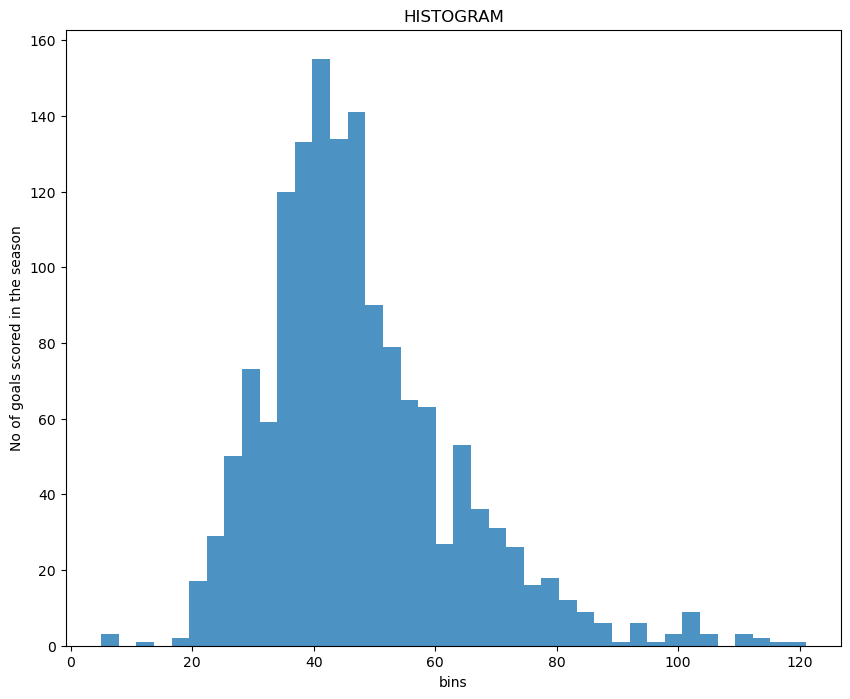

In [171]:
# checking the distribution of goals in the seasons
goals_08_to_16=melted_match.groupby(['season', 'Team'])['goals'].sum() 
# plot histogram
plot_visual(data=goals_08_to_16, data2='', visual_type='hist')
plt.title('HISTOGRAM')
plt.xlabel('bins')
plt.ylabel('No of goals scored in the season');

The graph shows that the distribution of goals is right screwed. Further investigation can be shown on the boxplot

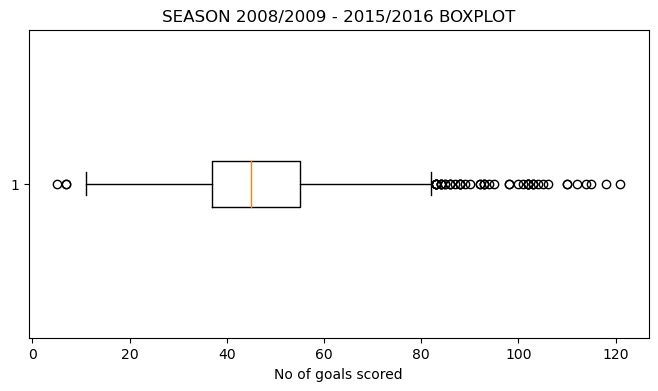

In [156]:
# plot box plot
plot_visual(data=goals_08_to_16, data2='', visual_type='boxplot')
plt.title('SEASON 2008/2009 - 2015/2016 BOXPLOT')
plt.xlabel('No of goals scored');

The distribution is rght skewed but with severa outliers

### Research Question 1 What is the league table for the 4 major leagues in europe during 2015/2016 season? 

In [157]:
melted_match['league_name'].value_counts()

England Premier League      6080
France Ligue 1              6080
Spain LIGA BBVA             6080
Italy Serie A               6034
Germany Bundesliga 1        4896
Netherlands Eredivisie      4896
Portugal Liga ZON Sagres    4104
Poland Ekstraklasa          3840
Scotland Premier League     3648
Belgium Jupiler League      3456
Switzerland Super League    2844
Name: league_name, dtype: int64

In [158]:
# Processing the data
columns_order = ['Pos', 'season', 'league_name', 'Club', 'MP', 'W', 'D', 'L', 'Pts', 'GF', 'GA', 'GD', 'avg_goals']
filtered_columns= ['Pos', 'Club', 'MP', 'W', 'D', 'L', 'Pts', 'GF', 'GA', 'GD', 'avg_goals']

def league_table(league):
    # Filter the data for the given league and season
    df_15_16 = (
        melted_match
        .query('season == "2015/2016" and league_name == @league')  
        .groupby(['season', 'league_name', 'Team'], as_index=False)
        .agg({
            'match_api_id': 'count',  # Total matches played
            'pts': [
                lambda x: (x == 3).sum(),  # Wins
                lambda x: (x == 1).sum(),  # Draws
                lambda x: (x == 0).sum(),  # Losses
                'sum'  # Total points
            ],
            'GF': 'sum',
            'GA': 'sum',
            'GD': 'sum',
            'goals': 'mean',  # Average goals
        })
    )

    # Flatten the column names
    df_15_16.columns = [
        'season', 'league_name', 'Club', 'MP', 
        'W', 'D', 'L', 'Pts', 'GF', 'GA', 'GD', 'avg_goals'
    ]

    # Sort the result by Pts and GD
    df_15_16 = df_15_16.sort_values(by=['Pts', 'GD'], ascending=[False, False])

    # Add a Rank column
    df_15_16['Pos'] = df_15_16.reset_index().index + 1
    # Reorder columns 
    df_15_16 = df_15_16[columns_order].reset_index()
    # filter columns
    df_15_16  = df_15_16[filtered_columns]


    return df_15_16

#### (a) England Premier League Table for 2015/2016 season

In [ ]:
table1=league_table(league="England Premier League")
# Display the table
print(table1)

    Pos                  Club  MP   W   D   L  Pts  GF  GA  GD  avg_goals
0     1        Leicester City  38  23  12   3   81  68  36  32   1.789474
1     2               Arsenal  38  20  11   7   71  65  36  29   1.710526
2     3     Tottenham Hotspur  38  19  13   6   70  69  35  34   1.815789
3     4       Manchester City  38  19   9  10   66  71  41  30   1.868421
4     5     Manchester United  38  19   9  10   66  49  35  14   1.289474
5     6           Southampton  38  18   9  11   63  59  41  18   1.552632
6     7       West Ham United  38  16  14   8   62  65  51  14   1.710526
7     8             Liverpool  38  16  12  10   60  63  50  13   1.657895
8     9            Stoke City  38  14   9  15   51  41  55 -14   1.078947
9    10               Chelsea  38  12  14  12   50  59  53   6   1.552632
10   11               Everton  38  11  14  13   47  59  55   4   1.552632
11   12          Swansea City  38  12  11  15   47  42  52 -10   1.105263
12   13               Watford  38  12 

#### (b) France Ligue 1 Table for 2015/2016 season

In [173]:
table2=league_table(league="France Ligue 1")
print(table2)

    Pos                    Club  MP   W   D   L  Pts   GF  GA  GD  avg_goals
0     1     Paris Saint-Germain  38  30   6   2   96  102  19  83   2.684211
1     2      Olympique Lyonnais  38  19   8  11   65   67  43  24   1.763158
2     3               AS Monaco  38  17  14   7   65   57  50   7   1.500000
3     4                OGC Nice  38  18   9  11   63   58  41  17   1.526316
4     5              LOSC Lille  38  15  15   8   60   39  27  12   1.026316
5     6        AS Saint-Étienne  38  17   7  14   58   42  37   5   1.105263
6     7                 SM Caen  38  16   6  16   54   39  52 -13   1.026316
7     8        Stade Rennais FC  38  13  13  12   52   52  54  -2   1.368421
8     9              Angers SCO  38  13  11  14   50   40  38   2   1.052632
9    10               SC Bastia  38  14   8  16   50   36  42  -6   0.947368
10   11   Girondins de Bordeaux  38  12  14  12   50   50  57  -7   1.315789
11   12  Montpellier Hérault SC  38  14   7  17   49   49  47   2   1.289474

#### (c) Spain LIGA BBVA Table for 2015/2016 season

In [174]:
table3=league_table(league="Spain LIGA BBVA")
print(table3)

    Pos                     Club  MP   W   D   L  Pts   GF  GA  GD  avg_goals
0     1             FC Barcelona  38  29   4   5   91  112  29  83   2.947368
1     2           Real Madrid CF  38  28   6   4   90  110  34  76   2.894737
2     3          Atletico Madrid  38  28   4   6   88   63  18  45   1.657895
3     4            Villarreal CF  38  18  10  10   64   44  35   9   1.157895
4     5  Athletic Club de Bilbao  38  18   8  12   62   58  45  13   1.526316
5     6         RC Celta de Vigo  38  17   9  12   60   51  59  -8   1.342105
6     7               Sevilla FC  38  14  10  14   52   51  50   1   1.342105
7     8                Malaga CF  38  12  12  14   48   38  35   3   1.000000
8     9            Real Sociedad  38  13   9  16   48   45  48  -3   1.184211
9    10               Real Betis  38  11  12  15   45   34  52 -18   0.894737
10   11              Valencia CF  38  11  11  16   44   46  48  -2   1.210526
11   12            UD Las Palmas  38  12   8  18   44   45  53  

#### (d) Italy Serie A Table for 2015/2016 season

In [175]:
table4=league_table(league="Italy Serie A")
print(table4)

    Pos           Club  MP   W   D   L  Pts  GF  GA  GD  avg_goals
0     1       Juventus  38  29   4   5   91  75  20  55   1.973684
1     2         Napoli  38  25   7   6   82  80  32  48   2.105263
2     3           Roma  38  23  11   4   80  83  41  42   2.184211
3     4          Inter  38  20   7  11   67  50  38  12   1.315789
4     5     Fiorentina  38  18  10  10   64  60  42  18   1.578947
5     6       Sassuolo  38  16  13   9   61  49  40   9   1.289474
6     7          Milan  38  15  12  11   57  49  43   6   1.289474
7     8          Lazio  38  15   9  14   54  52  52   0   1.368421
8     9  Chievo Verona  38  13  11  14   50  43  45  -2   1.131579
9    10          Genoa  38  13   7  18   46  45  48  -3   1.184211
10   11         Empoli  38  12  10  16   46  40  49  -9   1.052632
11   12         Torino  38  12   9  17   45  52  55  -3   1.368421
12   13       Atalanta  38  11  12  15   45  41  47  -6   1.078947
13   14        Bologna  38  11   9  18   42  33  45 -12   0.86

In [ ]:
path="C:/Users/Davie/Documents/GitHub/Investigating_dataset_project/"
# Function to write the table in readme file
def european_league_table (league, n):
    table = league_table(league=league)
    markdown_table = table.to_markdown(index=False)

    # Read the README.md content
    with open(path+'README.md', 'r') as f:
        content = f.read()
    # Replace the placeholder with the table
    updated_content = content.replace('<!-- TABLE_PLACEHOLDER'+ str(n) +' -->', f"\n### {league} League Table\n{markdown_table}\n")

    # Write the updated content back to the README.md
    with open(path+"README.md", "w") as f:
        f.write(updated_content)
    return  markdown_table

In [189]:
#european_league_table (league='England Premier League', n=1);

In [190]:
#european_league_table (league='France Ligue 1', n=2);

In [191]:
#european_league_table (league='Spain LIGA BBVA', n=3);

In [192]:
#european_league_table (league='Italy Serie A', n=4);

#### Saving for Google Looker Studio Analysis

In [194]:
df_google_looker = (
    melted_match
    .groupby(['season', 'league_name', 'Team'], as_index=False)
    .agg({
        'match_api_id': 'count',  # Total matches played
        'pts': [
            lambda x: (x == 3).sum(),  # Wins
            lambda x: (x == 1).sum(),  # Draws
            lambda x: (x == 0).sum(),  # Losses
            'sum'  # Total points
        ],
        'GF': 'sum',
        'GA': 'sum',
        'GD': 'sum',
        'goals': 'mean',  # Average goals
    })
)

# Flatten the column names
df_google_looker.columns = [
    'season', 'league_name', 'Club', 'MP', 
    'W', 'D', 'L', 'Pts', 'GF', 'GA', 'GD', 'avg_goals'
]

# Sort the result by total_pts
df_google_looker = df_google_looker.sort_values(by=['Pts', 'GD'], ascending=[False, False])

df_google_looker.reset_index().head(5)

,index,season,league_name,Club,MP,W,D,L,Pts,GF,GA,GD,avg_goals
0,999,2013/2014,Italy Serie A,Juventus,38,33,3,2,102,80,23,57,2.105263
1,725,2011/2012,Spain LIGA BBVA,Real Madrid CF,38,32,4,2,100,121,32,89,3.184211
2,902,2012/2013,Spain LIGA BBVA,FC Barcelona,38,32,4,2,100,115,40,75,3.026316
3,1061,2013/2014,Scotland Premier League,Celtic,38,31,6,1,99,102,25,77,2.684211
4,347,2009/2010,Spain LIGA BBVA,FC Barcelona,38,31,6,1,99,98,24,74,2.578947


In [754]:
# Saving
df_google_looker.to_excel('league_table_for_lookerStudio.xlsx', index_label='Id', index=False, encoding='utf-8')

### Research Question 2 Which are the top 3 teams from each league in 2015/2016 season? 

In [195]:
# Processing
top_3_teams = (
    melted_match
    .query('season=="2015/2016"')  
    .groupby(['season', 'league_name', 'Team'], as_index=False)['pts'] 
    .sum()
    .sort_values(by=['season', 'league_name', 'pts'], ascending=[True, True, False])
    .groupby(['season', 'league_name'], as_index=False)
    .head(3)
)
top_3_teams.head(5)

,season,league_name,Team,pts
0,2015/2016,Belgium Jupiler League,Club Brugge KV,64
1,2015/2016,Belgium Jupiler League,KAA Gent,60
8,2015/2016,Belgium Jupiler League,RSC Anderlecht,55
22,2015/2016,England Premier League,Leicester City,81
16,2015/2016,England Premier League,Arsenal,71
32,2015/2016,England Premier League,Tottenham Hotspur,70
50,2015/2016,France Ligue 1,Paris Saint-Germain,96
36,2015/2016,France Ligue 1,AS Monaco,65
48,2015/2016,France Ligue 1,Olympique Lyonnais,65
61,2015/2016,Germany Bundesliga 1,FC Bayern Munich,88


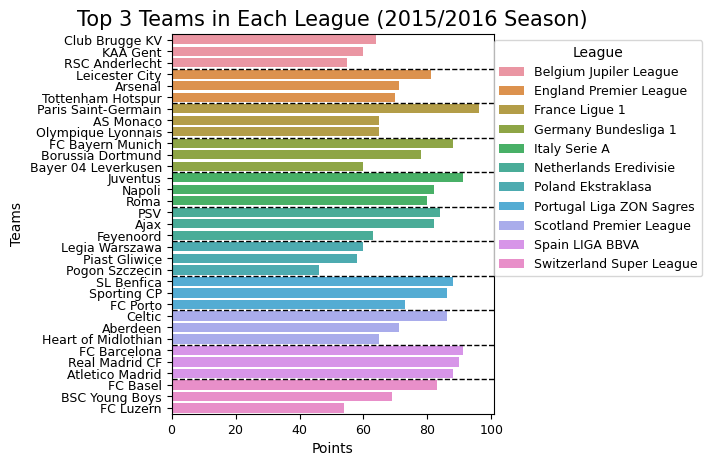

In [196]:
#plt.figure(figsize=(10, 7))
width_in_pixels = 969
height_in_pixels =643
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))


# Create a bar plot
sns.barplot(data=top_3_teams, x='pts', y='Team', hue='league_name', dodge=False)

# Add labels and title
plt.title('Top 3 Teams in Each League (2015/2016 Season)', fontsize=15)
plt.xlabel('Points', fontsize=10)
plt.ylabel('Teams', fontsize=10)
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)

# Add horizontal lines to separate leagues
league_boundaries = top_3_teams.groupby('league_name')['Team'].count().cumsum().values[:-1]
for boundary in league_boundaries:
    plt.axhline(y=boundary - 0.5, color='black', linestyle='--', linewidth=1)

# Add a legend
plt.legend(title='League', fontsize=9, title_fontsize=10, loc='upper left', bbox_to_anchor=(0.98,1)) 

# Show the plot
plt.tight_layout() 
# Saving the plot
plt.savefig('top3_legues.jpg', dpi=dpi, bbox_inches='tight')

plt.show();

### Research Question 3 What teams improved the most over the time period? 

- We use Year-Over-Year Improvements (YoY)
- The teams played different number of matches. We normalize Points Based on Total Matches Played
- Then divide the points by the total matches played in each season. 

In [197]:
# get the total points for each team per season
match_imp08_16=melted_match.query(
    'season in ["2008/2009", "2009/2010", "2010/2011", "2011/2012", "2012/2013", "2013/2014", "2014/2015", "2015/2016"]'
    ).groupby(
        ['season', 'Team'])['pts'].sum().unstack('season')

match_imp08_16.head(5)

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
AC Ajaccio,NaN,NaN,NaN,41.0,42.0,23.0,NaN,NaN
AC Arles-Avignon,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN
AC Bellinzona,43.0,25.0,32.0,NaN,NaN,NaN,NaN,NaN
ADO Den Haag,32.0,30.0,54.0,32.0,40.0,43.0,37.0,43.0
AJ Auxerre,55.0,71.0,49.0,34.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
Wolverhampton Wanderers,NaN,38.0,40.0,25.0,NaN,NaN,NaN,NaN
Xerez Club Deportivo,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN
Zaglebie Lubin,NaN,35.0,39.0,40.0,40.0,29.0,NaN,45.0


In [198]:
# get the total matches played for each team per season
match_impp08_16=melted_match.query(
    'season in ["2008/2009", "2009/2010", "2010/2011", "2011/2012", "2012/2013", "2013/2014", "2014/2015", "2015/2016"]'
    ).groupby(
        ['season', 'Team'])['match_api_id'].count().unstack('season')

match_impp08_16.head(5)

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
AC Ajaccio,NaN,NaN,NaN,38.0,38.0,38.0,NaN,NaN
AC Arles-Avignon,NaN,NaN,38.0,NaN,NaN,NaN,NaN,NaN
AC Bellinzona,36.0,36.0,36.0,NaN,NaN,NaN,NaN,NaN
ADO Den Haag,34.0,34.0,34.0,34.0,34.0,34.0,34.0,34.0
AJ Auxerre,38.0,38.0,38.0,38.0,NaN,NaN,NaN,NaN


In [199]:
# Divide points by number of matches played
df_normalized=match_imp08_16/match_impp08_16
df_normalized.dropna(how='any', inplace=True)
df_normalized.head(5)

season,2008/2009,2009/2010,2010/2011,2011/2012,2012/2013,2013/2014,2014/2015,2015/2016
Team,,,,,,,,
ADO Den Haag,0.941176,0.882353,1.588235,0.941176,1.176471,1.264706,1.088235,1.264706
AS Saint-Étienne,1.052632,1.052632,1.289474,1.500000,1.657895,1.815789,1.815789,1.526316
AZ,2.352941,1.823529,1.735294,1.911765,1.147059,1.382353,1.823529,1.735294
Aberdeen,1.394737,1.078947,1.000000,1.078947,1.263158,1.789474,1.973684,1.868421
Académica de Coimbra,1.300000,1.100000,1.000000,0.966667,0.933333,1.233333,0.852941,0.735294
...,...,...,...,...,...,...,...,...
VfL Wolfsburg,2.029412,1.470588,1.117647,1.294118,1.264706,1.764706,2.029412,1.323529
Vitesse,1.264706,0.941176,1.029412,1.558824,1.882353,1.617647,1.705882,1.352941
Vitoria Guimaraes,1.266667,1.366667,1.433333,1.500000,1.333333,1.166667,1.617647,1.176471


In [200]:
# Calculate YoY improvements
df_normalized['Total_YoY_Improvement']=(
    (df_normalized['2009/2010'] - df_normalized['2008/2009']) +
    (df_normalized['2010/2011'] - df_normalized['2009/2010']) +
    (df_normalized['2011/2012'] - df_normalized['2010/2011']) +
    (df_normalized['2012/2013'] - df_normalized['2011/2012']) +
    (df_normalized['2013/2014'] - df_normalized['2012/2013']) +
    (df_normalized['2014/2015'] - df_normalized['2013/2014']) +
    (df_normalized['2015/2016'] - df_normalized['2014/2015'])
    )

df_normalized[df_normalized['Total_YoY_Improvement']<0].reset_index().sort_values(by='Total_YoY_Improvement', ascending=False)

# save the data
df_normalized['Total_YoY_Improvement'].reset_index().to_excel('seasons_most_improved_team.xlsx', index=False, encoding='utf-8')

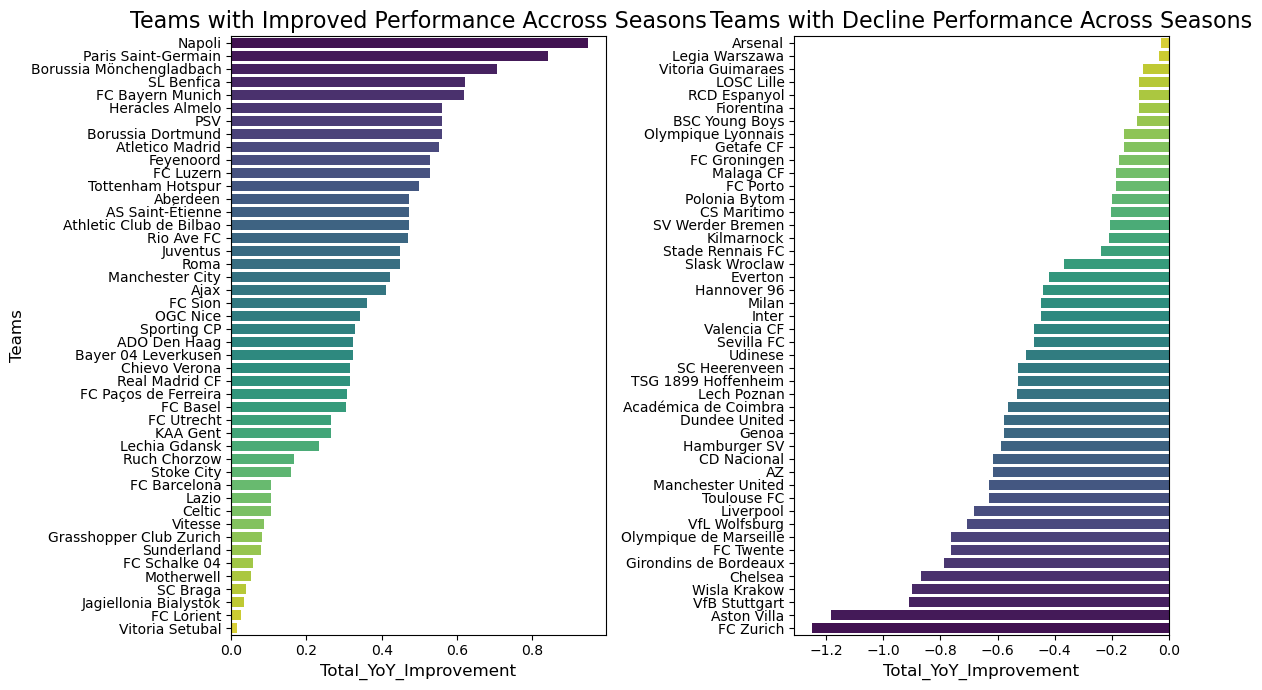

In [202]:
# improve
df0=df_normalized[df_normalized['Total_YoY_Improvement']>0].reset_index().sort_values(by='Total_YoY_Improvement', ascending=False)
# drop
df00=df_normalized[df_normalized['Total_YoY_Improvement']<0].reset_index().sort_values(by='Total_YoY_Improvement', ascending=False)

plt.figure(figsize=(12, 7))

# chart 1 improve
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
sns.barplot(data=df0, y='Team', x='Total_YoY_Improvement',dodge=False, palette='viridis')
plt.title('Teams with Improved Performance Accross Seasons', fontsize=16)
plt.xlabel('Total_YoY_Improvement', fontsize=12)
plt.ylabel('Teams', fontsize=12)

# chart 2 drop
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
sns.barplot(data=df00, y='Team', x='Total_YoY_Improvement',dodge=False, palette='viridis_r')
plt.title('Teams with Decline Performance Across Seasons', fontsize=16)
plt.xlabel('Total_YoY_Improvement', fontsize=12)
plt.ylabel('') 

# Show the plot
plt.tight_layout()

plt.show();

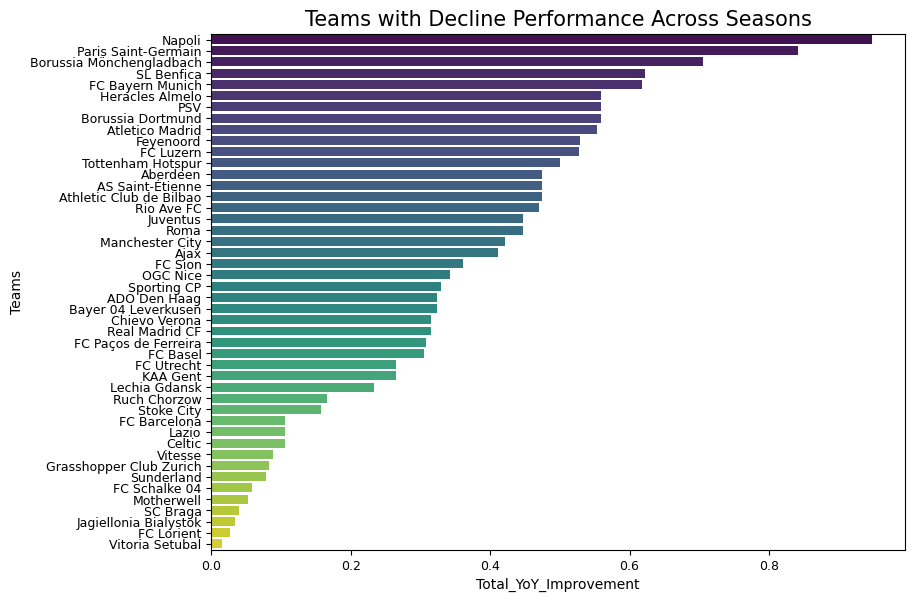

In [204]:
width_in_pixels = 971
height_in_pixels =643
dpi = 105
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

sns.barplot(data=df0, y='Team', x='Total_YoY_Improvement',dodge=False, palette='viridis')
plt.title('Teams with Decline Performance Across Seasons', fontsize=15)
plt.xlabel('Total_YoY_Improvement', fontsize=10)
plt.ylabel('Teams', fontsize=10)
plt.yticks(fontsize=9)
plt.xticks(fontsize=9)

# Show the plot
plt.tight_layout()
# Saving the plot
plt.savefig('improved_teams.jpg', dpi=dpi, bbox_inches='tight')

plt.show();

##### The most consistent improver is Napoli with a total YoY improvement of 0.9473684210526316 points.

### Insight 1: Team Playing Style Analysis
- Identify unique playing styles for teams

In [205]:
# Processing

# Team attributes against goals and points obtained
class_list =[]
for i in melted_match.columns:
    if 'Class' not in i:
        class_list.append(i)
class_list

['country_name',
 'league_name',
 'season',
 'stage',
 'date',
 'match_api_id',
 'home_team_goal',
 'away_team_goal',
 'results',
 'Location',
 'Team',
 'buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth',
 'goals',
 'pts',
 'GF',
 'GA',
 'GD']

In [206]:
exclude_list=['country_name', 'stage', 'date', 'match_api_id', 'home_team_goal', 'away_team_goal', 'results', 'Location']
req_columns=[
 'season',
 'league_name',
 'Team',
 'buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth',
 'goals',
 'pts',
 'GF',
 'GA',
 'GD']
num_columns=[ 'buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth']

In [208]:
melted_match[req_columns].head(5)

,season,league_name,Team,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,goals,pts,GF,GA,GD
0,2008/2009,Belgium Jupiler League,KRC Genk,58.0,52.0,38.0,67.0,48.0,56.0,47.0,45.0,55.0,1,1,1,1,0
1,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,54.0,42.0,51.0,47.0,52.0,32.0,44.0,58.0,37.0,0,1,0,0,0
2,2008/2009,Belgium Jupiler League,KSV Cercle Brugge,53.0,49.0,43.0,52.0,58.0,42.0,59.0,47.0,62.0,0,0,0,3,-3
3,2008/2009,Belgium Jupiler League,KAA Gent,50.0,55.0,37.0,28.0,66.0,34.0,55.0,59.0,52.0,5,3,5,0,5
4,2008/2009,Belgium Jupiler League,FCV Dender EH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,3,-2


In [209]:
melted_class = (
    melted_match.groupby(['season', 'league_name', 'Team'] + num_columns, as_index=False) 
    .agg({
        'match_api_id': 'count',  # Total matches played
        'pts': [
            lambda x: (x == 3).sum(),  # Wins
            lambda x: (x == 1).sum(),  # Draws
            lambda x: (x == 0).sum(),  # Losses
            'sum'  # Total points
        ],
        'GF': 'sum',
        'GA': 'sum',
        'GD': 'sum',
        'goals': 'mean',  # Average goals
    })
)

# Flatten the column names
melted_class.columns = [
    'season', 'league_name', 'Team'] + num_columns + ['MP', 
    'W', 'D', 'L', 'Pts', 'GF', 'GA', 'GD', 'Avg_Goals']

# Sort the result by total_pts
melted_class = melted_class.sort_values(by=['season', 'league_name', 'Pts'], ascending=[True, True, False])

melted_class.head(5)

,season,league_name,Team,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,...,defenceTeamWidth,MP,W,D,L,Pts,GF,GA,GD,Avg_Goals
8,2008/2009,Belgium Jupiler League,RSC Anderlecht,52.0,46.0,51.0,60.0,53.0,47.0,60.0,...,65.0,34,24,5,5,77,75,30,45,2.205882
13,2008/2009,Belgium Jupiler League,Standard de Liège,54.0,45.0,62.0,55.0,58.0,60.0,45.0,...,52.0,34,24,5,5,77,66,26,40,1.941176
0,2008/2009,Belgium Jupiler League,Club Brugge KV,42.0,52.0,45.0,42.0,57.0,47.0,51.0,...,57.0,34,18,5,11,59,59,50,9,1.735294
1,2008/2009,Belgium Jupiler League,KAA Gent,50.0,55.0,37.0,28.0,66.0,34.0,55.0,...,52.0,34,17,8,9,59,67,42,25,1.970588
10,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,54.0,42.0,51.0,47.0,52.0,32.0,44.0,...,37.0,34,16,7,11,55,55,36,19,1.617647


#### Normalize the numeric columns to ensure equal weighting during clustering.
- Use the relevant columns for clustering

In [210]:
# Select numeric columns for analysis
numeric_columns = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]

# Normalize the data
scaler = MinMaxScaler()
melted_class_normalized = melted_class.copy()
melted_class_normalized[numeric_columns] = scaler.fit_transform(melted_class[numeric_columns])

In [212]:
# Define the number of clusters
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
melted_class_normalized['Cluster'] = kmeans.fit_predict(melted_class_normalized[numeric_columns])

# Add cluster labels to the original data
melted_class['Cluster'] = melted_class_normalized['Cluster']

# Display the final dataframe
melted_class.head(5)

,season,league_name,Team,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,...,MP,W,D,L,Pts,GF,GA,GD,Avg_Goals,Cluster
8,2008/2009,Belgium Jupiler League,RSC Anderlecht,52.0,46.0,51.0,60.0,53.0,47.0,60.0,...,34,24,5,5,77,75,30,45,2.205882,0
13,2008/2009,Belgium Jupiler League,Standard de Liège,54.0,45.0,62.0,55.0,58.0,60.0,45.0,...,34,24,5,5,77,66,26,40,1.941176,1
0,2008/2009,Belgium Jupiler League,Club Brugge KV,42.0,52.0,45.0,42.0,57.0,47.0,51.0,...,34,18,5,11,59,59,50,9,1.735294,0
1,2008/2009,Belgium Jupiler League,KAA Gent,50.0,55.0,37.0,28.0,66.0,34.0,55.0,...,34,17,8,9,59,67,42,25,1.970588,0
10,2008/2009,Belgium Jupiler League,SV Zulte-Waregem,54.0,42.0,51.0,47.0,52.0,32.0,44.0,...,34,16,7,11,55,55,36,19,1.617647,3


#### Analyzing Clusters
- Calculate the average values of numeric columns for each cluster to interpret playing styles.

In [213]:
cluster_analysis = (
    melted_class
    .groupby('Cluster')[numeric_columns]
    .mean()
    .reset_index()
)
cluster_analysis

,Cluster,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,0,43.988722,44.902256,41.484962,49.135338,57.864662,48.526316,52.695489,51.229323,57.804511
1,1,59.409506,54.733090,48.819013,55.568556,55.389397,58.255941,47.844607,49.436929,54.425960
2,2,45.500000,50.487705,41.881148,45.020492,42.823770,50.454918,41.684426,47.610656,46.680328
3,3,58.127219,44.633136,57.816568,56.062130,56.313609,47.437870,38.615385,44.979290,46.553254


In [214]:
# Define the cluster labels
cluster_labels = {
    0: 'Balanced',
    1: 'Balanced-to-Offensive',
    2: 'Defensive',
    3: 'Offensive'  
}

# Rename clusters
cluster_analysis['Cluster'] = cluster_analysis['Cluster'].map(cluster_labels)
cluster_analysis

,Cluster,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,Balanced,43.988722,44.902256,41.484962,49.135338,57.864662,48.526316,52.695489,51.229323,57.804511
1,Balanced-to-Offensive,59.409506,54.733090,48.819013,55.568556,55.389397,58.255941,47.844607,49.436929,54.425960
2,Defensive,45.500000,50.487705,41.881148,45.020492,42.823770,50.454918,41.684426,47.610656,46.680328
3,Offensive,58.127219,44.633136,57.816568,56.062130,56.313609,47.437870,38.615385,44.979290,46.553254


#### Radar Chart Visualization
- Visualize the playing styles for each cluster using radar charts
- Offensive Playstyle: High buildUpPlayPassing, chanceCreationPassing, chanceCreationShooting. Low defencePressure and defenceAggression.
- Defensive Playstyle: High defencePressure, defenceAggression, and defenceTeamWidth. Low offensive attributes.
- Balanced Playstyle: Moderate values across both offensive and defensive attributes.

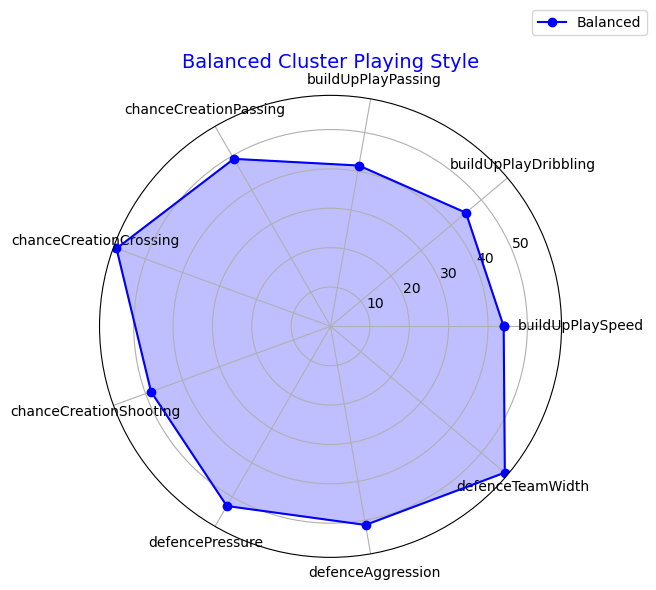

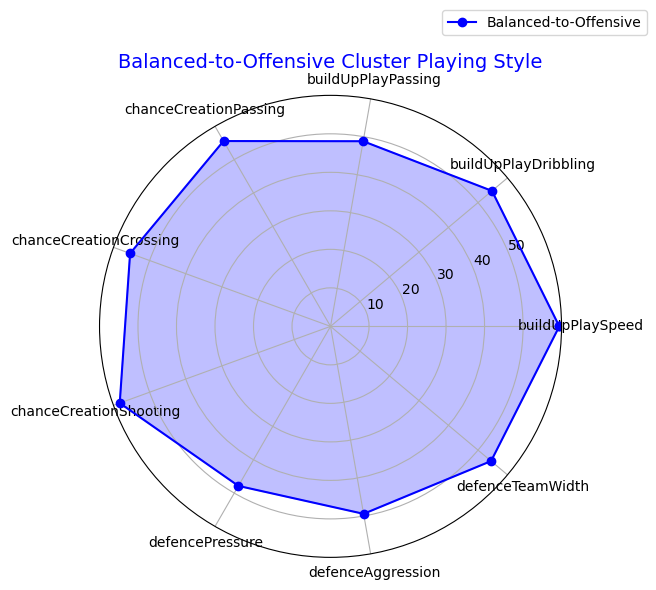

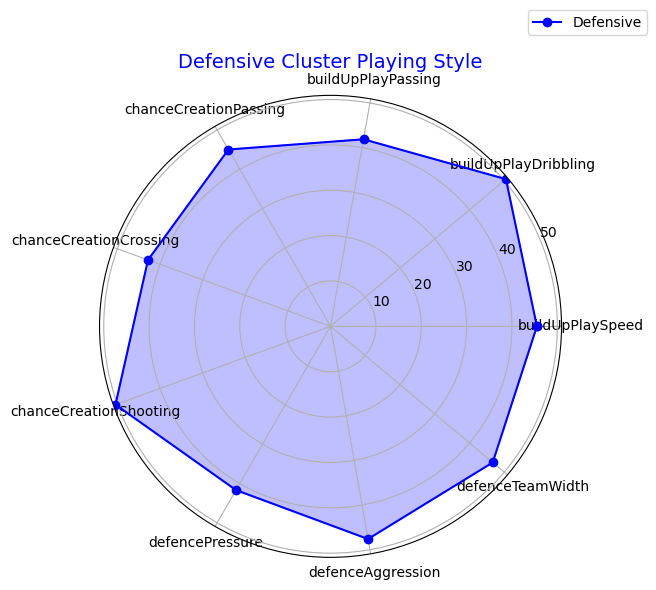

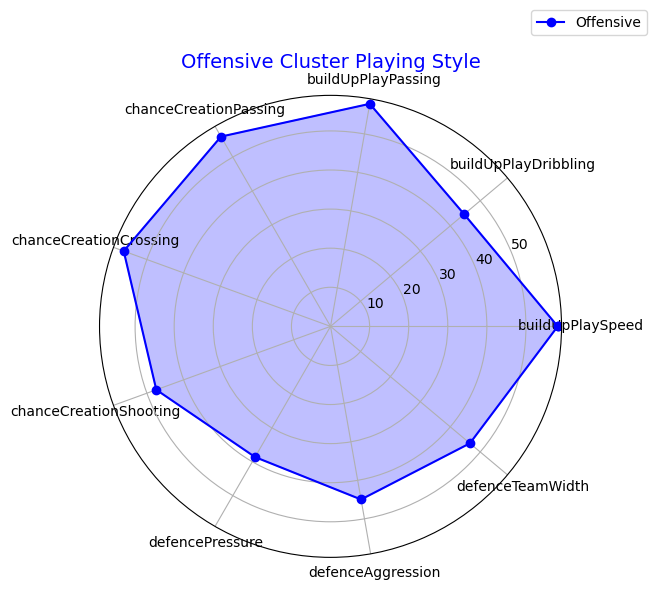

In [215]:
# Attributes
attributes = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing',
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]

# Angles for radar chart
angles = np.linspace(0, 2 * np.pi, len(attributes), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Iterate through each cluster
for cluster_label in cluster_analysis['Cluster'].unique():
    # Filter data for the current cluster
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == cluster_label]
    
    # Extract values
    cluster_values = cluster_data[attributes].values[0].tolist()
    cluster_values += cluster_values[:1]

    # Plot 
    plt.figure(figsize=(6, 6))
    plt.polar(angles, cluster_values, marker='o', color='blue', label=cluster_label)
    plt.fill(angles, cluster_values, color='blue', alpha=0.25)
    
    # Add labels
    plt.thetagrids(np.degrees(angles[:-1]), labels=attributes, fontsize=10)
    plt.title(f'{cluster_label} Cluster Playing Style', size=14, color='blue', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

    # Saving the plot
    plt.savefig('Cluster_Playing_Style.jpg', dpi=300, bbox_inches='tight')
    plt.show();


####  Comparing Clusters with Performance Metrics

In [216]:
# Merge clusters with performance metrics
performance_analysis = melted_class[['Team', 'Cluster', 'Pts', 'GF', 'GA', 'GD']]

# Group by cluster and analyze average performance
performance_by_cluster = (
    performance_analysis
    .groupby('Cluster')[['Pts', 'GF', 'GA', 'GD']]
    .mean()
    .reset_index()
)

performance_by_cluster

,Cluster,Pts,GF,GA,GD
0,0,52.477444,51.703008,45.417293,6.285714
1,1,51.687386,50.228519,45.411335,4.817185
2,2,45.426230,44.815574,47.590164,-2.774590
3,3,45.210059,45.168639,51.547337,-6.378698


In [217]:
# Define the cluster labels
cluster_labels = {
    0: 'Offensive',
    1: 'Balanced',
    2: 'Defensive-to-Balanced',
    3: 'Weak Defensive'  
}

# Rename the clusters
performance_by_cluster['Cluster'] = performance_by_cluster['Cluster'].map(cluster_labels)

#### Visualize performance differences using bar chart.

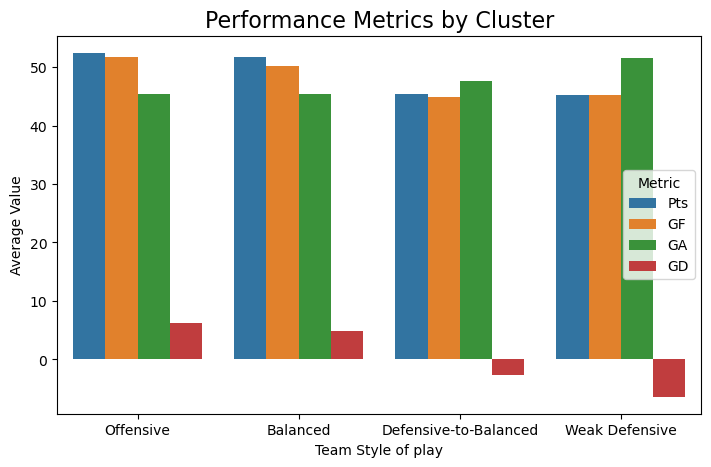

In [218]:
#plt.figure(figsize=(10, 7))
# Set the figure size in inches (Width, Height)
width_in_pixels = 974
height_in_pixels =645
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

sns.barplot(data=performance_by_cluster.melt(id_vars='Cluster'), x='Cluster', y='value', hue='variable')

plt.title('Performance Metrics by Cluster', fontsize=16)
plt.xlabel('Team Style of play')
plt.ylabel('Average Value')
plt.legend(title='Metric', loc='center right') #bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10

plt.tight_layout()

# Saving the plot
plt.savefig('play_stylety.jpg', dpi=dpi, bbox_inches='tight')
plt.show();

#### Conclusion

- Radar charts helps to identify the offensive, defensive, or balanced styles of each cluster.
- From the performance metrics, offensive and balanced styles are the most effective playing styles

### Insight 2: Analysisng the correlation of Attributes with Performance
- Determine how specific attributes impact performance

In [ ]:
# Select numeric columns for analysis
numeric_columns = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
                   'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
                   'defencePressure', 'defenceAggression', 'defenceTeamWidth', 
                   'GF', 'GA', 'GD', 'pts', 'goals']

# Filter relevant columns
correlation_data = melted_match[numeric_columns]

# Correlation matrix
correlation_matrix = correlation_data.corr()
correlation_matrix # table

#### Visualize the correlation matrix in a heatmap

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='cividis_r', cbar=True)
plt.title('Correlation Between Class Attributes and Performance Metrics')

plt.show();

#### Visualize the correlation Between Build-Up Play Passing and Goals Scored on a Scatter

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=melted_class, x='buildUpPlayPassing', y='GF')

plt.title('Correlation Between Build-Up Play Passing and Goals Scored (GF)')
plt.xlabel('Build-Up Play Passing')
plt.ylabel('Goals Scored (GF)')
plt.show()

#### Regression for buildUpPlayPassing and GF

In [ ]:
X = melted_class[['buildUpPlayPassing']]
y = melted_class['GF']

# Add a constant for the regression
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Display results
model.summary()

### Insight 3: League-Level Style Analysis
- Assess the dominant strategies in different leagues.

In [779]:
# Style-related columns
style_columns = [
    'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
    'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
    'defencePressure', 'defenceAggression', 'defenceTeamWidth'
]
league_style_analysis = melted_match.groupby(['season','league_name'])[style_columns].mean().reset_index()

league_style_analysis.to_excel('league_style_analysis_for_lookerStudio.xlsx', index=False, encoding='utf-8')

#### Bar Plot

In [ ]:
# Melt the data
league_style_melted = league_style_analysis.melt(
    id_vars=['season', 'league_name'], 
    var_name='Style Attribute', 
    value_name='Average Value'
)

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=league_style_melted, y='Average Value', x='Style Attribute', hue='league_name', palette='Paired')

plt.title('Average Playing Styles Across Leagues', fontsize=16)
plt.xlabel('Style Attribute', fontsize=12)
plt.ylabel( 'Average Value', fontsize=12)
plt.xticks(rotation=90)

plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10) 
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Saving the plot
plt.savefig('league_playing_style.jpg', dpi=300, bbox_inches='tight')
plt.show();

#### Heatmap

In [ ]:
# Plot heatmap
#plt.figure(figsize=(12, 6))
# Set the figure size in inches (Width, Height)
width_in_pixels = 1024
height_in_pixels =643
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

league_style_analysis = melted_match.groupby('league_name')[style_columns].mean().reset_index()
sns.heatmap(league_style_analysis.set_index('league_name'), annot=True, fmt='.0f', cmap='viridis')

plt.title('Heatmap of Average Playing Styles by League', fontsize=16)
plt.xlabel('Style Attribute', fontsize=12)
plt.ylabel('League', fontsize=12)
plt.tight_layout()

# Saving the plot
plt.savefig('heatmap_play_style.jpg', dpi=dpi, bbox_inches='tight')
plt.show();

#### Conclusion

- Italy Serie A, Scotland Premeir League and England Premier League have higher buildUpPlaySpeed, indicating a faster playing style.
- Italy Serie A focuses more on chanceCreationPassing and chanceCreationShooting.


#### Insight 4: Summary Statistics for players

##### (a) Summary statistics for numeric columns

In [ ]:
player_info

In [783]:
numeric_columns = ['height', 'weight', 'overall_rating', 'potential']
summary_stats = player_info[numeric_columns].describe().T


In [ ]:
summary_stats['median'] = player_info[numeric_columns].median()
summary_stats

##### (b) Distribution of the preferred_foot

In [ ]:
foot_distribution = player_info['preferred_foot'].value_counts()

# Plot a bar chart
sns.barplot(x=foot_distribution.index, y=foot_distribution.values, palette='pastel')
plt.title('Distribution of Preferred Foot', fontsize=16)
plt.xlabel('Preferred Foot', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

##### (c) Attacking and Defensive work rates

In [ ]:
attacking_work_rate_dist = player_info['attacking_work_rate'].value_counts()
defensive_work_rate_dist = player_info['defensive_work_rate'].value_counts()

print("Attacking Work Rate Distribution:")
print(attacking_work_rate_dist)

print("\nDefensive Work Rate Distribution:")
print(defensive_work_rate_dist)


In [ ]:
# Combine the two distributions for visualization
work_rate_data = pd.DataFrame({
    'Attacking Work Rate': attacking_work_rate_dist,
    'Defensive Work Rate': defensive_work_rate_dist
}).T

# Create a grouped bar chart
work_rate_data.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightcoral'])

plt.title('Distribution of Work Rates', fontsize=16)
plt.xlabel('Work Rate Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Work Rate Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Insight 5: Tracking trends of the Player Attributes over time

In [788]:
# Players attribute categories

Overall_Performance= ['overall_rating', 'potential']

Physical_Attributes= ['acceleration', 'sprint_speed', 'agility', 'balance', 'stamina', 'strength', 'jumping']

Technical_Skills= ['dribbling', 'ball_control', 'short_passing', 'long_passing', 'crossing', 'finishing', 'heading_accuracy',
                   'volleys', 'curve', 'free_kick_accuracy', 'long_shots', 'shot_power']

Defensive_Skills= ['interceptions', 'marking', 'standing_tackle', 'sliding_tackle']

Mental_Attributes= ['reactions', 'vision', 'positioning', 'aggression']

Goalkeeping_Attributes= ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']

Others= ['preferred_foot', 'attacking_work_rate', 'defensive_work_rate', 'age']

In [789]:
# Important attributes
attributes = [
    'overall_rating',
    'potential',
    'acceleration',
    'sprint_speed',
    'dribbling',
    'ball_control',
    'short_passing',
    'finishing',
    'interceptions',
    'stamina'
]

In [ ]:
# Calculate the attributes and group by 'date' 
trend_data = player_info.groupby('date')[attributes].mean().reset_index()
trend_data

In [791]:
# saving
trend_data.to_excel('player_attributes_trends_over_time.xlsx', index=False, encoding='utf-8')

In [ ]:
# Plot the trends
plt.figure(figsize=(10, 6))
for attribute in attributes:
    sns.lineplot(data=trend_data, x='date', y=attribute, label=attribute, marker='o')

plt.title('Trend Analysis of Player Attributes Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Value', fontsize=12)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

In [ ]:
# Resample to monthly averages
trend_data_monthly = trend_data.set_index('date').resample('M')[attributes].mean().reset_index()
trend_data_monthly

In [ ]:
# Plotting the resampled data
#plt.figure(figsize=(10, 7))
# Set the figure size in inches (Width, Height)
width_in_pixels = 974
height_in_pixels =644
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

for attribute in attributes:
    sns.lineplot(data=trend_data_monthly, x='date', y=attribute, label=attribute, marker='o')

plt.title('Monthly Trend Analysis of Player Attributes', fontsize=15)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Average Value', fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(30)

plt.legend(title='Attributes', bbox_to_anchor=(1,1), loc='upper left', fontsize=10) #
plt.tight_layout()

# Saving the plot
plt.savefig('trend.jpg', dpi=dpi, bbox_inches='tight') 
plt.show();

#### Insight 6: Analyzing Player Development over time
- Aggregate player's data over time

In [ ]:
# Identify some players
for i in player_info['player_name'].unique():
    if 'Henry' in i:
        print(i)

In [ ]:
# Data to track individual player trends grouped by 'date' and 'player_name'
player_trends = player_info.groupby(['date', 'player_name'])[attributes].mean().reset_index()
player_trends

In [498]:
player_trends.to_excel('playes_dev_trends.xlsx', index=False, encoding='utf-8')

##### (a) Lionel Messi

In [ ]:
# Filter data for Lionel Messi
messi_data = player_trends[player_trends['player_name'] == 'Lionel Messi']

# Melt the data
messi_melted = messi_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=messi_melted, x='date', y='Value', hue='Attribute', marker='o')

# Titles and labels
plt.title('Player Development for Lionel Messi', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)


plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

##### (b) Thierry Henry

In [ ]:
# Filter data for Thierry Henry
thierry_data = player_trends[player_trends['player_name'] == 'Thierry Henry']

# Melt the data
thierry_melted = thierry_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=thierry_melted, x='date', y='Value', hue='Attribute', marker='o')

plt.title('Player Development for Thierry Henry', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();


##### (c) Ronaldinho

In [ ]:
# Filter data for Ronaldinho
ronaldinho_data = player_trends[player_trends['player_name'] == 'Ronaldinho']

# Melt the data
ronaldinho_melted = ronaldinho_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=ronaldinho_melted, x='date', y='Value', hue='Attribute', marker='o')

plt.title('Player Development for Ronaldinho', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();


##### (d) Cristiano Ronaldo

In [ ]:
# Filter data for Cristiano Ronaldo
cristiano_data = player_trends[player_trends['player_name'] == 'Cristiano Ronaldo']

# Melt the data
cristiano_melted = cristiano_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=cristiano_melted, x='date', y='Value', hue='Attribute', marker='o')

plt.title('Player Development for Cristiano Ronaldo', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

##### (e) Mikel Arteta

In [ ]:
# Filter data for Mikel Arteta
arteta_data = player_trends[player_trends['player_name'] == 'Mikel Arteta']

# Melt the data
arteta_melted = arteta_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=arteta_melted, x='date', y='Value', hue='Attribute', marker='o')

plt.title('Player Development for Mikel Arteta', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

In [ ]:
# Filter data for Mikel Arteta
owen_data = player_trends[player_trends['player_name'] == 'Michael Owen']

# Melt the data
owen_melted = owen_data.melt(id_vars='date', value_vars=attributes, 
                               var_name='Attribute', value_name='Value')

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=owen_melted, x='date', y='Value', hue='Attribute', marker='o')

plt.title('Player Development for Michael Owen', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Attribute Value', fontsize=12)
plt.ylim(0)

plt.legend(title='Attributes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

##### (-) Comparison betweeen Cristiano Ronaldo and Lionel Messi Development

In [ ]:
#plt.figure(figsize=(12, 7))
# Set the figure size in inches (Width, Height)
width_in_pixels = 1934
height_in_pixels =644
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))


# chart 1 improve
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
sns.lineplot(data=cristiano_melted, x='date', y='Value', hue='Attribute', style='Attribute', marker='o', legend=False)
plt.title('Player Development for Cristiano Ronaldo', fontsize=15)
plt.xlabel('Date', fontsize=11)
plt.ylabel('Attribute Value', fontsize=11)
plt.ylim(20)

# chart 2 drop
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
sns.lineplot(data=messi_melted, x='date', y='Value', hue='Attribute', style='Attribute', marker='o')
plt.title('Player Development for Lionel Messi', fontsize=15)
plt.xlabel('Date', fontsize=11)
plt.ylabel('')
plt.ylim(20)

plt.legend(title='Attributes',  bbox_to_anchor=(1, 1),loc='upper left') #
# Show the plot
plt.tight_layout()
# Saving the plot
plt.savefig('compare_dev_trend.jpg', dpi=dpi, bbox_inches='tight') 

plt.show();

Refined Attributes for Messi vs. Ronaldo
overall_rating - Provides a comprehensive view of their overall abilities.
dribbling - Reflects close ball control and creativity (key for both players).
finishing - Measures scoring ability in critical moments.
vision - Highlights playmaking and ability to create opportunities.
positioning - Shows tactical awareness and ability to exploit spaces.
stamina - Represents endurance and ability to maintain performance.
agility - Captures Messi's quick turns and Ronaldo's athleticism.
free_kick_accuracy - Differentiates their set-piece capabilities.
Why These Attributes?
Messi's Strengths: Dribbling, vision, agility, and positioning align with his playmaking and creativity.
Ronaldo's Strengths: Finishing, free-kick accuracy, stamina, and positioning highlight his physical dominance and goal-scoring prowess.
Shared Traits: Overall rating, dribbling, and positioning showcase their elite skills.

In [823]:
attributes = [
    'overall_rating',
    'dribbling',
    'finishing',
    'positioning',
    'stamina',
    'free_kick_accuracy'
]#'vision','agility',

In [824]:
player_trends = player_info.groupby(['date', 'player_name'])[attributes].mean().reset_index()

In [825]:
comp_data = player_trends[(player_trends['player_name'] == 'Lionel Messi') | (player_trends['player_name'] == 'Cristiano Ronaldo')]
comp_data=comp_data.groupby(['date', 'player_name'])[attributes].max().reset_index()

In [ ]:
comp_melted_data = comp_data.melt(id_vars=['date','player_name' ], value_vars=attributes, 
                               var_name='Attribute', value_name='Value')
comp_melted_data[~comp_melted_data.isna()].reset_index()
cris_messi_compared=comp_melted_data[['date',	'player_name',	'Attribute',	'Value']]
cris_messi_compared

In [ ]:
# Set the figure size in inches (Width, Height)
width_in_pixels = 140
height_in_pixels =900
dpi = 100
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

# Create a Seaborn FacetGrid
g = sns.FacetGrid(cris_messi_compared, col="Attribute", col_wrap=3, hue="player_name", height=3.19, aspect=0.851) #1.2
g.map(sns.lineplot, "date", "Value", marker='o', linewidth=2)

# Add a title to the FacetGrid
plt.subplots_adjust(top=0.85)  
plt.suptitle('Comparison of Player\'s Development Over Time:\n Cristiano Ronaldo vs. Lionel Messi', 
             fontsize=16, ha='center', va='top', weight='bold') #Comparison of Attribute Development Over Time: Cristiano Ronaldo vs. Lionel Messi


# Add legend with a title 
g.add_legend(title="Player Name", bbox_to_anchor=(0.8, 0.95),loc='upper left')

# Set column titles for each facet
g.set_titles("{col_name}")

# Set x-axis labels
for ax in g.axes.flat:
    ax.set_xticks(pd.to_datetime(["2008", "2010", "2012", "2014", "2016"]))
    ax.set_xticklabels(["2008", "2010", "2012", "2014", "2016"], fontsize=10)

# Saving the plot
plt.savefig('compare_dev_trend.jpg', dpi=dpi, bbox_inches='tight') 

# Show the plot
plt.show();

In [ ]:

comp_melted_data = comp_data.melt(id_vars=['date','player_name' ], value_vars=attributes, 
                               var_name='Attribute', value_name='Value')
comp_melted_data[~comp_melted_data.isna()].reset_index()
cris_messi_compared=comp_melted_data[['date',	'player_name',	'Attribute',	'Value']]

# Set the figure size in inches (Width, Height)
width_in_pixels = 1400
height_in_pixels =642
dpi = 120
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

# plot
g = sns.FacetGrid(cris_messi_compared, col='Attribute', col_wrap=4, height=3, sharey=False)

g.map(sns.lineplot, "date", "Value", hue=cris_messi_compared["player_name"], marker='o', linewidth=2)

# Add legend with a title and set column titles for each facet
g.add_legend(title="Player Name", bbox_to_anchor=(0.8, 1),loc='upper left')
g.set_titles("{col_name}")

# Set axis labels
g.set_axis_labels('Date','Value', fontsize=9)

'''# Set axis labels with font size
for i, ax in enumerate(g.axes.flat):
    ax.set_xlabel("Date", fontsize=9)
    ax.set_xticks(pd.to_datetime(["2008", "2010", "2012", "2014", "2016"]))
    ax.set_xticklabels(["2008", "2010", "2012", "2014", "2016"], fontsize=9, rotation=45)
    if i == 0:  # Add y-axis label only to the first chart
        ax.set_ylabel("Value", fontsize=9)
    else:
        ax.set_ylabel("")'''


for ax in g.axes.flat:
    ax.set_xlabel("Date", fontsize=9)
    ax.set_ylabel("Value", fontsize=9)
    ax.set_xticks(pd.to_datetime(["2008", "2010", "2012", "2014", "2016"]))
    ax.set_xticklabels(["2008", "2010", "2012", "2014", "2016"], fontsize=9)


plt.subplots_adjust(top=0.9)  
plt.figtext(0.5, 1, "Attribute Development Over Time: Cristiano Ronaldo vs. Lionel Messi", 
            fontsize=16, ha="center", va="top", weight="bold")

# Saving the plot
plt.savefig('compare_dev_trend.jpg', dpi=dpi, bbox_inches='tight') 

# Show the plot
plt.show();

#### Insight 7: Player Age and, Overal Rating and  Potential
- Players are at different age in different seasons
- We use birthday and date columns to calculate player age and analyze:
- (a) Age distribution.
- (b) Relationship between age and potential or overall_rating.
- (c) Peak performance age for players.

In [507]:
# Convert 'birthday' and 'date' to datetime format
player_info['birthday'] = pd.to_datetime(player_info['birthday'])
player_info['date'] = pd.to_datetime(player_info['date'])

# Calculate ages
player_info['age'] = (player_info['date'] - player_info['birthday']).astype('<m8[Y]')

##### (a) Age distribution

In [ ]:
# Check the distribution of age column
player_info['age'].describe()

In [ ]:
# Data
age_dis=player_info.copy()
age_dis.drop_duplicates()

plt.figure(figsize=(10, 7))
# Plot the histogram
sns.histplot(age_dis['age'], kde=True, bins=37, color='skyblue')

plt.title('Age Distribution of Players', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Saving the plot
plt.savefig('age_hist.jpg', dpi=300, bbox_inches='tight') 

plt.show();

##### (b) Relationship Between Age, Potential and Overall Rating
- Examine how age relates to potential and overall_rating

In [510]:
# Data
age_vs_potential_rating = player_info.groupby(['player_api_id', 'age'])[['overall_rating', 'potential']].mean()
age_vs_potential_rating  = age_vs_potential_rating .reset_index()

In [ ]:
#Age vs. Potential
plt.figure(figsize=(8, 6))

sns.scatterplot(data=age_vs_potential_rating , x='age', y='potential', color='orange')
plt.title('Age vs Potential', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Potential', fontsize=12)
plt.ylim(0)

plt.show();

In [ ]:
# Age vs. Overall Rating
plt.figure(figsize=(8, 6))

sns.scatterplot(data=age_vs_potential_rating , x='age', y='overall_rating', color='green')
plt.title('Age vs Overall Rating', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Overall Rating', fontsize=12)
plt.ylim(0)

plt.show();

##### (c) Peak performance age for players
- Identify (a) at what age a player attains Maximum rating (b) the age with the highest average ratings.

In [ ]:
# Calculate the age at which most players reach their maximum rating
max_ratings = player_info.groupby(['player_api_id', 'age'])['overall_rating'].max().reset_index().sort_values(by=['player_api_id','overall_rating'], ascending=[True, False])
max_ratings.drop_duplicates(subset='player_api_id', inplace=True)

# Most common age at peak
peak_age = max_ratings['age'].mode()[0]  

#plt.figure(figsize=(10, 6))
# Set the figure size in inches (Width, Height)
width_in_pixels = 971
height_in_pixels =642
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

# Scatter plot of age vs. overall rating
sns.scatterplot(data=max_ratings, x='age', y='overall_rating', color='green', alpha=0.6, label='Player Ratings')
# Add a trend line
sns.regplot(data=max_ratings, x='age', y='overall_rating', scatter=False, color='blue', label='Trend Line')

# Highlight the most common peak age
plt.axvline(peak_age, color='red', linestyle='--', label=f'Peak Age: {int(peak_age)}')

plt.title('Age vs Overall Rating with Peak Analysis', fontsize=16)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Overall Rating', fontsize=12)
plt.ylim(0)

# Add a legend
plt.legend(loc=4, fontsize=10)
plt.tight_layout()

# Saving the plot
plt.savefig('age_rating.jpg', dpi=dpi, bbox_inches='tight') 
plt.show();

##### Creating age-group

In [ ]:
# Age bins
bins = [0, 15, 18, 21, 24, 27, 30, 33, 36, 39, 41, 44] 
# Corresponding labels
labels = ['Under 15', '15-18', '18-21', '21-24', '24-27', '27-30', '30-33', '33-36', '36-39', '39-41', '41-44']  

# Create the age_group column
player_info['age_group'] = pd.cut(player_info['age'], bins=bins, labels=labels, right=False)

# Display a sample to verify
player_info[['age', 'age_group']]

In [ ]:
# Group by age group and calculate mean and max values
age_mean_rating = player_info.groupby('age_group')[['potential', 'overall_rating']].mean().reset_index()
age_max_rating = player_info.groupby('age_group')[['potential', 'overall_rating']].max().reset_index()

# Identify peak rating ages
peak_mean_age = age_mean_rating.loc[age_mean_rating['overall_rating'].idxmax(), 'age_group']
peak_max_age = age_max_rating.loc[age_max_rating['overall_rating'].idxmax(), 'age_group']

# Plot Age Group vs Ratings
#plt.figure(figsize=(10, 7))
# Set the figure size in inches (Width, Height)
width_in_pixels = 971
height_in_pixels =642
dpi = 135
fig = plt.figure(figsize=(width_in_pixels/dpi, height_in_pixels/dpi))

# Mean lines
sns.lineplot(data=age_mean_rating, x='age_group', y='potential', label='Mean Potential', color='orange', linewidth=2)
sns.lineplot(data=age_mean_rating, x='age_group', y='overall_rating', label='Mean Overall Rating', color='green', linewidth=2)

# Max lines
sns.lineplot(data=age_max_rating, x='age_group', y='potential', label='Max Potential', color='orange', linestyle='--', linewidth=2)
sns.lineplot(data=age_max_rating, x='age_group', y='overall_rating', label='Max Overall Rating', color='green', linestyle='--', linewidth=2)

# Highlight peak ages
plt.axvline(x=peak_max_age, color='red', linestyle='--', label=f'Peak Max Age: {peak_max_age}')
plt.axvline(x=peak_mean_age, color='blue', linestyle='--', label=f'Peak Mean Age: {peak_mean_age}')

# Customize plot
plt.title('Age Group vs Potential and Overall Rating (Mean & Max)', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.ylim(0)
plt.legend(title='Attributes',  loc=4)
plt.tight_layout()

# Saving the plot
plt.savefig('agegroup_rating.jpg', dpi=dpi, bbox_inches='tight') 
plt.show();

perform Attribute Clustering using K-Means:

In [516]:
# List of attributes
attributes = ['dribbling', 'ball_control', 'short_passing', 'long_passing', 'crossing', 'finishing', 'heading_accuracy',
              'volleys', 'curve', 'free_kick_accuracy', 'long_shots', 'shot_power', 'acceleration', 'sprint_speed', 
              'agility', 'balance', 'stamina', 'strength', 'jumping', 'interceptions', 'marking', 'standing_tackle', 
              'sliding_tackle', 'reactions', 'vision', 'positioning', 'aggression', 'gk_diving', 'gk_handling', 
              'gk_kicking', 'gk_positioning', 'gk_reflexes']

In [517]:
# Define attribute groups
archetypes = {
    'Goalkeeper': ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
    'Defender': ['marking', 'standing_tackle', 'sliding_tackle', 'interceptions', 'strength'],
    'Midfielder': ['short_passing', 'long_passing', 'vision', 'ball_control', 'stamina'],
    'Winger': ['dribbling', 'crossing', 'acceleration', 'sprint_speed', 'agility'],
    'Striker': ['finishing', 'volleys', 'long_shots', 'shot_power', 'positioning'],
}

In [ ]:
player_attr_data = player_info.groupby('player_name')[attributes].max().reset_index()
player_attr_data.head(5)

In [519]:
# Select the data for clustering, i.e. not normalized
clustered_df = player_attr_data[attributes]

In [ ]:
# Cluster Players
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(clustered_df)

# Add the cluster labels to the player DataFrame
player_attr_data['cluster_id'] = clusters

# Calculate mean attribute values for each cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=attributes)
cluster_centers

In [521]:
# Dict for calculated dynamic threshold based on cluster center means
archetype_scores = {}

# Dict to map clusters to archetypes
archetype_mapping = {}

for cluster_id in cluster_centers.index:
    cluster_mean = cluster_centers.loc[cluster_id]
    
    # Average score for each archetype
    archetype_scores = {
        'Goalkeeper': cluster_mean[archetypes['Goalkeeper']].mean(),
        'Defender': cluster_mean[archetypes['Defender']].mean(),
        'Midfielder': cluster_mean[archetypes['Midfielder']].mean(),
        'Winger': cluster_mean[archetypes['Winger']].mean(),
        'Striker': cluster_mean[archetypes['Striker']].mean(),
    }
    
    # Striker
    striker_score = (cluster_mean['finishing'] + cluster_mean['volleys'] + cluster_mean['shot_power'] + cluster_mean['positioning']) / 4
    
    # Map archetype to the cluster with highest score
    if striker_score > 70:
        archetype_mapping[cluster_id] = 'Striker'
    else:
        best_archetype = max(archetype_scores, key=archetype_scores.get)
        archetype_mapping[cluster_id] = best_archetype

In [ ]:
print(archetype_scores)
print(archetype_mapping)

In [ ]:
# Apply the mapping
player_attr_data['archetype'] = player_attr_data['cluster_id'].map(archetype_mapping)

# Results
player_attr_data[['player_name', 'cluster_id', 'archetype']].head(5)

In [ ]:
# Check the mapping results
player_attr_data[player_attr_data['player_name']=='Lionel Messi']

In [ ]:
# Group by archetype and calculate mean attributes
archetype_summary = player_attr_data.groupby('archetype')[attributes].mean()
archetype_summary

In [ ]:
# Plot archetype distribution
plt.figure(figsize=(10, 7))

sns.countplot(data=player_attr_data, y='archetype', order=['Winger', 'Defender', 'Midfielder', 'Striker', 'Goalkeeper'])
plt.title('Player Archetype Distribution')
plt.xlabel('Count')
plt.ylabel('Archetypes')

# Saving the plot
plt.savefig('archetype.jpg', dpi=300, bbox_inches='tight') 
plt.show();

In [ ]:
# Visualize attribute means for each archetype
archetype_summary.T.plot(kind='bar', figsize=(12, 6), colormap='turbo_r') 

plt.title('Average Attributes by Archetype')
plt.xlabel('Attributes')
plt.ylabel('Mean Value')
plt.legend(title='Archetypes',  bbox_to_anchor=(1.05, 1), loc='upper left')

# Saving the plot
plt.savefig('attribute.jpg', dpi=300, bbox_inches='tight') 
plt.show();

## Conclusions
The soccer database has five datasets, league, country, player, player attribute, team and team attribute. It is a detailed dabase for European major leagues covering several seasons from 2008/2009 t0 2015/2016. 

The project seeks to answer three questions, what teams improved the most over the time period, which players had the most penalties and which was the the most preferred leg for penalty-takers in 2016 among the players who scored more than the mean penalties in that year?

In attempting to find solutions to the question, each dataset was examineed for inconsistencies, colomn names, corrected, missing values replace or droped in certain datasets before they were finally merged and cleaned. Visual presentations created and inteprated.

From the analysis and visualization, Richie Lambert is the player who scored most of the penalties. I also found that Paris Saint-Germain is the most improved team over the period of time given, followed by Napoli and Cracovia being the in the third position. Moreover, the findings also indicate that most of the penalty takers in 2016 preferred right leg compared to the right leg. The findings also shows that the distribution of the number of goals scored in the two seasons are right skewed.

Whereas I was able to show that there is a correltaion between the number of goals scored in the two extreme seasons (2008/2009 and 2015/2016), theer are  other seasons that were not considered. There is likelihood that a team that improved between the two seasons might not have improved in the seasons prior 2015/2016. Goal difference between the two seasons was used as a measured of improvement in performance because the ultimate objective of team managers, players and teams is to improve to score goals, but there could be criteria for measuring performance.

In [528]:
#from subprocess import call
#call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])